# Simulacao leitos - camas limitadas

In [1]:
# Import required modules

import simpy
import random
from random import expovariate, seed
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
class g:
    """g holds Global variables. No individual instance is required"""
    
    cases_arriving = 40
    inter_arrival_time = 1/cases_arriving  # Average time (days) between arrivals
    los = 13  # Average length of stay in hospital (days)
    los_uti = 5  # Average length of stay in hospital (days)
    sim_duration = 360  # Duration of simulation (days)
    audit_interval = 1  # Interval between audits (days)
    
    total_beds = 800
    total_beds_icu = 520
    occupation_rate = 0.4
    icu_occupation_rate = 0.6
    
    icu_rate = 0.1
    icu_after_bed = 0.08
    
    beds = int(total_beds * (1 - occupation_rate))  # beds available
    icu_beds = int(total_beds_icu * (1 - icu_occupation_rate)) # icu beds available

In [3]:
class Hospital:
    """
    Hospital class holds:
    1) Dictionary of patients present
    2) List of audit times
    3) List of beds occupied at each audit time
    4) Current total beds occupied
    5) Current total icu beds occupied
    6) Admissions to data

    Methods:

    __init__: Set up hospital instance

    audit: records number of beds occupied

    build_audit_report: builds audit report at end of run (calculate 5th, 50th
    and 95th percentile bed occupancy.

    chart: plot beds occupied over time (at end of run)
    """

    def __init__(self):
        """
        Constructor method for hospital class"
        Initialise object with attributes.
        """

        self.patients = {}  # Dictionary of patients present
        self.patients_in_queue = {}
        
        self.patients_in_beds = {}
        self.patients_in_icu_beds = {}
        
        self.audit_time = []  # List of audit times
        self.audit_beds = []  # List of beds occupied at each audit time
        self.audit_icu_beds = []  # List of icu beds occupied at each audit time
        self.audit_queue = []
        
        self.bed_count = 0  # Current total beds occupied
        self.bed_icu_count = 0
        self.queue_count = 0
        self.admissions = 0  # Admissions to data
        
        return

    def audit(self, time):
        """
        Audit method. When called appends current simulation time to audit_time
        list, and appends current bed count to audit_beds.
        """
        self.audit_time.append(time)
        self.audit_beds.append(self.bed_count)
        self.audit_icu_beds.append(self.bed_icu_count)
        self.audit_queue.append(self.queue_count)
        
        return

    def build_audit_report(self):
        """
        This method is called at end of run. It creates a pandas DataFrame,
        transfers audit times and bed counts to the DataFrame, and 
        calculates/stores 5th, 50th and 95th percentiles.
        """
        self.audit_report = pd.DataFrame()

        self.audit_report['Time'] = self.audit_time

        self.audit_report['Occupied_beds'] = self.audit_beds
        
        self.audit_report['ICU_Occupied_beds'] = self.audit_icu_beds

        self.audit_report['Median_beds'] = \
            self.audit_report['Occupied_beds'].quantile(0.5)
        
        self.audit_report['ICU_Median_beds'] = \
            self.audit_report['ICU_Occupied_beds'].quantile(0.5)

        self.audit_report['Beds_5_percent'] = \
            self.audit_report['Occupied_beds'].quantile(0.05)

        self.audit_report['ICU_Beds_5_percent'] = \
            self.audit_report['ICU_Occupied_beds'].quantile(0.05)
        
        self.audit_report['Beds_95_percent'] = \
            self.audit_report['Occupied_beds'].quantile(0.95)
        
        self.audit_report['ICU_Beds_95_percent'] = \
            self.audit_report['ICU_Occupied_beds'].quantile(0.95)

        self.audit_report['Queue'] = self.audit_queue

        self.audit_report['Median_queue'] = \
            self.audit_report['Queue'].quantile(0.5)

        self.audit_report['Queue_5_percent'] = \
            self.audit_report['Queue'].quantile(0.05)

        self.audit_report['Queue_95_percent'] = \
            self.audit_report['Queue'].quantile(0.95)

        return self.audit_report

    def chart(self):
        """
        This method is called at end of run. It plots beds occupancy over the
        model run, with 5%, 50% and 95% percentiles.
        """

        # Plot occupied beds

        plt.plot(self.audit_report['Time'],
                 self.audit_report['Occupied_beds'],
                 color='k',
                 marker='o',
                 linestyle='solid',
                 markevery=1,
                 label='Occupied beds')

        plt.plot(self.audit_report['Time'],
                 self.audit_report['Beds_5_percent'],
                 color='0.5',
                 linestyle='dashdot',
                 markevery=1,
                 label='5th percentile')

        plt.plot(self.audit_report['Time'],
                 self.audit_report['Median_beds'],
                 color='0.5',
                 linestyle='dashed',
                 label='Median')

        plt.plot(self.audit_report['Time'],
                 self.audit_report['Beds_95_percent'],
                 color='0.5',
                 linestyle='dashdot',
                 label='95th percentile')

        plt.xlabel('Day')
        plt.ylabel('Occupied beds')
        plt.title(
            'Occupied beds (individual days with 5th, 50th and 95th ' +
            'percentiles)')
        plt.legend()
        plt.show()
        
        
        # Plot occupied icu beds

        plt.plot(self.audit_report['Time'],
                 self.audit_report['ICU_Occupied_beds'],
                 color='k',
                 marker='o',
                 linestyle='solid',
                 markevery=1,
                 label='Occupied icu beds')
        
        plt.plot(self.audit_report['Time'],
                 self.audit_report['ICU_Beds_5_percent'],
                 color='0.5',
                 linestyle='dashdot',
                 markevery=1,
                 label='5th percentile')

        plt.plot(self.audit_report['Time'],
                 self.audit_report['ICU_Median_beds'],
                 color='0.5',
                 linestyle='dashed',
                 label='Median')

        plt.plot(self.audit_report['Time'],
                 self.audit_report['ICU_Beds_95_percent'],
                 color='0.5',
                 linestyle='dashdot',
                 label='95th percentile')
        
        plt.xlabel('Day')
        plt.ylabel('Occupied icu beds')
        plt.title(
            'Occupied icu beds (individual days with 5th, 50th and 95th ' +
            'percentiles)')
        plt.legend()
        plt.show()
        

        # Plot queue for beds

        plt.plot(self.audit_report['Time'],
                 self.audit_report['Queue'],
                 color='k',
                 marker='o',
                 linestyle='solid',
                 markevery=1, label='Occupied beds')

        plt.plot(self.audit_report['Time'],
                 self.audit_report['Queue_5_percent'],
                 color='0.5',
                 linestyle='dashdot',
                 markevery=1,
                 label='5th percentile')

        plt.plot(self.audit_report['Time'],
                 self.audit_report['Median_queue'],
                 color='0.5',
                 linestyle='dashed',
                 label='Median')

        plt.plot(self.audit_report['Time'],
                 self.audit_report['Queue_95_percent'],
                 color='0.5',
                 linestyle='dashdot',
                 label='95th percentile')

        plt.xlabel('Day')
        plt.ylabel('Queue for beds')
        plt.title('Queue for beds (individual days with 5th, 50th and 95th' +
                  ' percentiles)')
        plt.legend()
        plt.show()

        return

In [4]:
class Model:
    """
    The main model class.

    The model class contains the model environment. The modelling environment
    is set up, and patient arrival and audit processes initiated. Patient
    arrival triggers a spell for that patient in hospital. Arrivals and audit
    continue for the duration of the model run. The audit is then 
    summarised and bed occupancy (with 5th, 50th and 95th percentiles) plotted.

    Methods are:

    __init__: Set up model instance

    audit_beds: call for bed audit at regular intervals (after initial delay 
    for model warm-up)

    new_admission: trigger new admissions to hospital at regular intervals.
    Call for patient generation with patient id and length of stay, then call
    for patient spell in hospital.

    run: Controls the main model run. Initialises model and patient arrival and
    audit processes. Instigates the run. At end of run calls for an audit
    summary and bed occupancy plot.

    spell_gen: stores patient in hospital patient list and bed queue 
    dictionaries, waits for bed resource to become available, then removes 
    patient from bed queue dictionary and adds patient to hospital bed 
    dictionary and increments beds occupied. Waits for the patient length of
    stay in the hospital and then decrements beds occupied and removes patient
    from hospital patient dictionary and beds occupied dictionary.
    """

    def __init__(self):
        """
        Constructor class for new model.
        """
        self.env = simpy.Environment()

        return

    def audit_beds(self, delay):
        """
        Bed audit process. Begins by applying delay, then calls for audit at
        intervals set in g.audit_interval

        :param delay: delay (days) at start of model run for model warm-up.
        """

        # Delay first audit
        yield self.env.timeout(delay)

        # Continually generate audit requests until end of model run
        while True:
            # Call audit (pass simulation time to hospital.audit)
            self.hospital.audit(self.env.now)
            # Delay until next call
            yield self.env.timeout(g.audit_interval)

        return

    def new_admission(self, interarrival_time, los, los_uti):
        """
        New admissions to hospital.

        :param interarrival_time: average time (days) between arrivals
        :param los: average length of stay (days)
        """
        while True:
            # Increment hospital admissions count
            self.hospital.admissions += 1

            # Generate new patient object (from Patient class). Give patient id
            # and set length of stay from inverse exponential distribution).
            p = Patient(patient_id=self.hospital.admissions,
                        los=random.expovariate(1 / los),
                        los_uti=random.expovariate(1 / los_uti))
            print('Patient %d arriving %7.2f, admissions count %d' %(p.id,self.env.now,self.hospital.admissions))

            # Add patient to hospital patient dictionary
            self.hospital.patients[p.id] = p

            # Generate a patient spell in hospital (by calling spell method).
            # This triggers a patient admission and allows the next arrival to
            # be set before the paitent spell is finished
            self.spell = self.spell_gen(p)
            self.env.process(self.spell)

            # Set and call delay before looping back to new patient admission
            next_admission = random.expovariate(1 / interarrival_time)
            #print('Next patient in %f3.2' %next_admission)
            yield self.env.timeout(next_admission)

        return

    def spell_gen(self, p):
        """
        Patient hospital stay generator. Increment bed count, wait for patient
        length of stay to complete, then decrement bed count and remove patient
        from hospital patient dictionary

        :param p: patient object (contains length of stay for patient)
        """
        # The following 'with' defines the required resources and automatically
        # releases resources when no longer required
        
        # screening - bed or icu bed
        is_icu = 1 if random.uniform(0, 1) > (1-g.icu_rate) else 0
        
        # bed
        if is_icu == 0:
            
            with self.resources.beds.request() as req:
                # Increment queue count
                self.hospital.queue_count += 1
                print('Patient %d arriving queue %7.2f, queue count %d' %(p.id,self.env.now,self.hospital.queue_count))

                # Add patient to dictionary of queuing patients. This is not used
                # further in this model.
                self.hospital.patients_in_queue[p.id] = p

                # Yield resource request. Sim continues after yield when resources
                # are vailable (so there is no delay if resources are immediately
                # available)
                yield req

                # Resource now available. Remove from queue count and dictionary of
                # queued objects
                self.hospital.queue_count -= 1
                del self.hospital.patients_in_queue[p.id]
                print('Patient %d leaving queue %7.2f, queue count %d' %(p.id,self.env.now,self.hospital.queue_count))

                # Add to count of patients in beds and to dictionary of patients in
                # beds
                self.hospital.patients_in_beds[p.id] = p
                self.hospital.bed_count += 1
                print('Patient %d arriving bed %7.2f, bed count %d' %(p.id,self.env.now,self.hospital.bed_count))

                # Trigger length of stay delay
                yield self.env.timeout(p.los)

                # Length of stay complete. Remove patient from counts and
                # dictionaries
                self.hospital.bed_count -= 1
                print('Patient %d leaving bed %7.2f, bed count %d' %(p.id,self.env.now,self.hospital.bed_count))
                del self.hospital.patients_in_beds[p.id]
            
            # needs icu
            after_is_icu = 1 if random.uniform(0, 1) > (1-g.icu_after_bed) else 0
            
            if after_is_icu == 1:
                
                with self.resources_icu.icu_beds.request() as icu_req:
                    
                    # Increment queue count
                    self.hospital.bed_count += 1
                    print('Patient %d waiting icu %7.2f, bed count %d' %(p.id,self.env.now,self.hospital.bed_count))
                
                    # Add patient to dictionary of icu queuing patients. This is not used
                    # further in this model.
                    self.hospital.patients_in_beds[p.id] = p
                
                    # Yield resource request. Sim continues after yield when resources
                    # are vailable (so there is no delay if resources are immediately
                    # available)
                    yield icu_req
                
                    # Resource now available. Remove from queue count and dictionary of
                    # queued objects
                    self.hospital.bed_count -= 1
                    del self.hospital.patients_in_beds[p.id]
                    print('Patient %d leaving bed %7.2f, queue bed %d' %(p.id,self.env.now,self.hospital.bed_count))
                
                    # Add to count of patients in icu beds and to dictionary of patients in
                    # icu beds
                    self.hospital.patients_in_icu_beds[p.id] = p
                    self.hospital.bed_icu_count += 1
                    print('Patient %d arriving icu bed %7.2f, icu bed count %d' %(p.id,self.env.now,self.hospital.bed_icu_count))
                
                    # Trigger length of stay delay
                    yield self.env.timeout(p.los_uti)
                
                    # Length of stay complete. Remove patient from counts and
                    # dictionaries
                    self.hospital.bed_icu_count -= 1
                    print('Patient %d leaving icu bed %7.2f, icu bed count %d' %(p.id,self.env.now,self.hospital.bed_icu_count))
                    del self.hospital.patients_in_icu_beds[p.id]
                    del self.hospital.patients[p.id]
        
        # icu bed
        else:
                    
            with self.resources_icu.icu_beds.request() as icu_req:
                
                # Increment queue count
                self.hospital.queue_count += 1
                print('Patient %d arriving queue %7.2f, queue count %d' %(p.id,self.env.now,self.hospital.queue_count))
                
                # Add patient to dictionary of icu queuing patients. This is not used
                # further in this model.
                self.hospital.patients_in_queue[p.id] = p
                
                # Yield resource request. Sim continues after yield when resources
                # are vailable (so there is no delay if resources are immediately
                # available)
                yield icu_req
                
                # Resource now available. Remove from queue count and dictionary of
                # queued objects
                self.hospital.queue_count -= 1
                del self.hospital.patients_in_queue[p.id]
                print('Patient %d leaving queue %7.2f, queue count %d' %(p.id,self.env.now,self.hospital.queue_count))
                
                # Add to count of patients in icu beds and to dictionary of patients in
                # icu beds
                self.hospital.patients_in_icu_beds[p.id] = p
                self.hospital.bed_icu_count += 1
                print('Patient %d arriving icu bed %7.2f, icu bed count %d' %(p.id,self.env.now,self.hospital.bed_icu_count))
                
                # Trigger length of stay delay
                yield self.env.timeout(p.los_uti)
                
                # Length of stay complete. Remove patient from counts and
                # dictionaries
                self.hospital.bed_icu_count -= 1
                print('Patient %d leaving icu bed %7.2f, icu bed count %d' %(p.id,self.env.now,self.hospital.bed_icu_count))
                del self.hospital.patients_in_icu_beds[p.id]
                del self.hospital.patients[p.id]

        return
    
    def run(self):
        """
        Controls the main model run. Initialises model and patient arrival and
        audit processes. Instigates the run. At end of run calls for an audit
        summary and bed occupancy plot
        """

        # Set up hospital (calling Hospital class)
        self.hospital = Hospital()

        # Set up resources (beds, icu_beds)
        self.resources = Resources(self.env, g.beds)
        self.resources_icu = Resources_ICU(self.env, g.icu_beds)

        # Set up starting processes: new admissions and bed  audit (with delay)
        self.env.process(self.new_admission(g.inter_arrival_time, g.los, g.los_uti))
        self.env.process(self.audit_beds(delay=20))

        # Start model run
        self.env.run(until=g.sim_duration)

        # At end of run call for bed audit summary and bed occupancy plot
        self.hospital.build_audit_report()
        #self.hospital.chart()

        return

In [5]:
class Patient:
    """
    Patient class. Contains patient id and length of stay (it could contain
    other info about patient, such as priority or clinical group.

    The only method is __init__ for creating a patient (with assignment of
    patient id and length of stay).
    """

    def __init__(self, patient_id, los, los_uti):
        """
        Contructor for new patient.

        :param patient_id: id of patient  (set in self.new_admission)
        :param los: length of stay (days, set in self.new_admission)
        """
        self.id = patient_id
        self.los = los
        self.los_uti = los_uti

        return

In [6]:
class Resources:
    """
    Holds beds resources
    """

    def __init__(self, env, number_of_beds):
        """        Constructor method to initialise beds resource)"""
        self.beds = simpy.Resource(env, capacity=number_of_beds)

        return

In [7]:
class Resources_ICU:
    """
    Holds icu beds resources
    """

    def __init__(self, env, number_of_icu_beds):
        """        Constructor method to initialise icu beds resource)"""
        self.icu_beds = simpy.Resource(env, capacity=number_of_icu_beds)

        return

In [8]:
def main():
    """
    Code entry point after: if __name__ == '__main__'
    Creates model object, and runs model
    """

    model = Model()
    model.run()

    return

In [9]:
## Code entry point. Calls main method.
#if __name__ == '__main__':
#    main()

In [10]:
model = Model()

In [11]:
%%time
seed(98989)
model.run()

Patient 1 arriving    0.00, admissions count 1
Patient 1 arriving queue    0.00, queue count 1
Patient 1 leaving queue    0.00, queue count 0
Patient 1 arriving bed    0.00, bed count 1
Patient 2 arriving    0.01, admissions count 2
Patient 2 arriving queue    0.01, queue count 1
Patient 2 leaving queue    0.01, queue count 0
Patient 2 arriving bed    0.01, bed count 2
Patient 3 arriving    0.02, admissions count 3
Patient 3 arriving queue    0.02, queue count 1
Patient 3 leaving queue    0.02, queue count 0
Patient 3 arriving bed    0.02, bed count 3
Patient 4 arriving    0.03, admissions count 4
Patient 4 arriving queue    0.03, queue count 1
Patient 4 leaving queue    0.03, queue count 0
Patient 4 arriving bed    0.03, bed count 4
Patient 5 arriving    0.04, admissions count 5
Patient 5 arriving queue    0.04, queue count 1
Patient 5 leaving queue    0.04, queue count 0
Patient 5 arriving bed    0.04, bed count 5
Patient 6 arriving    0.05, admissions count 6
Patient 6 arriving queu

Patient 159 arriving bed    3.43, bed count 130
Patient 30 leaving bed    3.43, bed count 129
Patient 160 arriving    3.45, admissions count 160
Patient 160 arriving queue    3.45, queue count 1
Patient 160 leaving queue    3.45, queue count 0
Patient 160 arriving bed    3.45, bed count 130
Patient 161 arriving    3.50, admissions count 161
Patient 161 arriving queue    3.50, queue count 1
Patient 161 leaving queue    3.50, queue count 0
Patient 161 arriving bed    3.50, bed count 131
Patient 162 arriving    3.50, admissions count 162
Patient 162 arriving queue    3.50, queue count 1
Patient 162 leaving queue    3.50, queue count 0
Patient 162 arriving bed    3.50, bed count 132
Patient 140 leaving bed    3.50, bed count 131
Patient 163 arriving    3.57, admissions count 163
Patient 163 arriving queue    3.57, queue count 1
Patient 163 leaving queue    3.57, queue count 0
Patient 163 arriving bed    3.57, bed count 132
Patient 164 arriving    3.60, admissions count 164
Patient 164 arri

Patient 263 arriving    6.15, admissions count 263
Patient 263 arriving queue    6.15, queue count 1
Patient 263 leaving queue    6.15, queue count 0
Patient 263 arriving bed    6.15, bed count 190
Patient 264 arriving    6.15, admissions count 264
Patient 264 arriving queue    6.15, queue count 1
Patient 264 leaving queue    6.15, queue count 0
Patient 264 arriving bed    6.15, bed count 191
Patient 265 arriving    6.16, admissions count 265
Patient 265 arriving queue    6.16, queue count 1
Patient 265 leaving queue    6.16, queue count 0
Patient 265 arriving bed    6.16, bed count 192
Patient 266 arriving    6.18, admissions count 266
Patient 266 arriving queue    6.18, queue count 1
Patient 266 leaving queue    6.18, queue count 0
Patient 266 arriving bed    6.18, bed count 193
Patient 267 arriving    6.22, admissions count 267
Patient 267 arriving queue    6.22, queue count 1
Patient 267 leaving queue    6.22, queue count 0
Patient 267 arriving bed    6.22, bed count 194
Patient 26

Patient 340 arriving    8.16, admissions count 340
Patient 340 arriving queue    8.16, queue count 1
Patient 340 leaving queue    8.16, queue count 0
Patient 340 arriving bed    8.16, bed count 226
Patient 341 arriving    8.18, admissions count 341
Patient 341 arriving queue    8.18, queue count 1
Patient 341 leaving queue    8.18, queue count 0
Patient 341 arriving bed    8.18, bed count 227
Patient 269 leaving bed    8.19, bed count 226
Patient 269 waiting icu    8.19, bed count 227
Patient 269 leaving bed    8.19, queue bed 226
Patient 269 arriving icu bed    8.19, icu bed count 23
Patient 298 leaving icu bed    8.20, icu bed count 22
Patient 342 arriving    8.22, admissions count 342
Patient 342 arriving queue    8.22, queue count 1
Patient 342 leaving queue    8.22, queue count 0
Patient 342 arriving bed    8.22, bed count 227
Patient 343 arriving    8.23, admissions count 343
Patient 343 arriving queue    8.23, queue count 1
Patient 343 leaving queue    8.23, queue count 0
Patien

Patient 437 arriving icu bed   10.57, icu bed count 27
Patient 438 arriving   10.60, admissions count 438
Patient 438 arriving queue   10.60, queue count 1
Patient 438 leaving queue   10.60, queue count 0
Patient 438 arriving bed   10.60, bed count 274
Patient 220 leaving bed   10.63, bed count 273
Patient 439 arriving   10.63, admissions count 439
Patient 439 arriving queue   10.63, queue count 1
Patient 439 leaving queue   10.63, queue count 0
Patient 439 arriving icu bed   10.63, icu bed count 28
Patient 440 arriving   10.64, admissions count 440
Patient 440 arriving queue   10.64, queue count 1
Patient 440 leaving queue   10.64, queue count 0
Patient 440 arriving icu bed   10.64, icu bed count 29
Patient 52 leaving bed   10.65, bed count 272
Patient 431 leaving icu bed   10.68, icu bed count 28
Patient 250 leaving bed   10.68, bed count 271
Patient 441 arriving   10.71, admissions count 441
Patient 441 arriving queue   10.71, queue count 1
Patient 441 leaving queue   10.71, queue c

Patient 488 arriving   12.03, admissions count 488
Patient 488 arriving queue   12.03, queue count 1
Patient 488 leaving queue   12.03, queue count 0
Patient 488 arriving bed   12.03, bed count 291
Patient 489 arriving   12.03, admissions count 489
Patient 489 arriving queue   12.03, queue count 1
Patient 489 leaving queue   12.03, queue count 0
Patient 489 arriving bed   12.03, bed count 292
Patient 490 arriving   12.05, admissions count 490
Patient 490 arriving queue   12.05, queue count 1
Patient 490 leaving queue   12.05, queue count 0
Patient 490 arriving bed   12.05, bed count 293
Patient 491 arriving   12.06, admissions count 491
Patient 491 arriving queue   12.06, queue count 1
Patient 491 leaving queue   12.06, queue count 0
Patient 491 arriving bed   12.06, bed count 294
Patient 482 leaving bed   12.06, bed count 293
Patient 368 leaving bed   12.07, bed count 292
Patient 492 arriving   12.07, admissions count 492
Patient 492 arriving queue   12.07, queue count 1
Patient 492 l

Patient 526 arriving icu bed   12.65, icu bed count 30
Patient 520 leaving bed   12.65, bed count 314
Patient 520 waiting icu   12.65, bed count 315
Patient 520 leaving bed   12.65, queue bed 314
Patient 520 arriving icu bed   12.65, icu bed count 31
Patient 264 leaving bed   12.67, bed count 313
Patient 527 arriving   12.67, admissions count 527
Patient 527 arriving queue   12.67, queue count 1
Patient 527 leaving queue   12.67, queue count 0
Patient 527 arriving bed   12.67, bed count 314
Patient 528 arriving   12.67, admissions count 528
Patient 528 arriving queue   12.67, queue count 1
Patient 528 leaving queue   12.67, queue count 0
Patient 528 arriving bed   12.67, bed count 315
Patient 529 arriving   12.73, admissions count 529
Patient 529 arriving queue   12.73, queue count 1
Patient 529 leaving queue   12.73, queue count 0
Patient 529 arriving bed   12.73, bed count 316
Patient 283 leaving bed   12.73, bed count 315
Patient 530 arriving   12.74, admissions count 530
Patient 53

Patient 620 arriving bed   15.04, bed count 334
Patient 621 arriving   15.04, admissions count 621
Patient 621 arriving queue   15.04, queue count 1
Patient 621 leaving queue   15.04, queue count 0
Patient 621 arriving bed   15.04, bed count 335
Patient 622 arriving   15.04, admissions count 622
Patient 622 arriving queue   15.04, queue count 1
Patient 622 leaving queue   15.04, queue count 0
Patient 622 arriving bed   15.04, bed count 336
Patient 623 arriving   15.08, admissions count 623
Patient 623 arriving queue   15.08, queue count 1
Patient 623 leaving queue   15.08, queue count 0
Patient 623 arriving icu bed   15.08, icu bed count 31
Patient 94 leaving icu bed   15.13, icu bed count 30
Patient 624 arriving   15.13, admissions count 624
Patient 624 arriving queue   15.13, queue count 1
Patient 624 leaving queue   15.13, queue count 0
Patient 624 arriving icu bed   15.13, icu bed count 31
Patient 625 arriving   15.13, admissions count 625
Patient 625 arriving queue   15.13, queue 

Patient 724 leaving queue   17.34, queue count 0
Patient 724 arriving bed   17.34, bed count 368
Patient 725 arriving   17.36, admissions count 725
Patient 725 arriving queue   17.36, queue count 1
Patient 725 leaving queue   17.36, queue count 0
Patient 725 arriving bed   17.36, bed count 369
Patient 423 leaving icu bed   17.41, icu bed count 26
Patient 726 arriving   17.41, admissions count 726
Patient 726 arriving queue   17.41, queue count 1
Patient 726 leaving queue   17.41, queue count 0
Patient 726 arriving bed   17.41, bed count 370
Patient 386 leaving bed   17.42, bed count 369
Patient 193 leaving bed   17.42, bed count 368
Patient 193 waiting icu   17.42, bed count 369
Patient 193 leaving bed   17.42, queue bed 368
Patient 193 arriving icu bed   17.42, icu bed count 27
Patient 727 arriving   17.42, admissions count 727
Patient 727 arriving queue   17.42, queue count 1
Patient 727 leaving queue   17.42, queue count 0
Patient 727 arriving bed   17.42, bed count 369
Patient 137 

Patient 833 leaving queue   20.30, queue count 0
Patient 833 arriving bed   20.30, bed count 395
Patient 834 arriving   20.30, admissions count 834
Patient 834 arriving queue   20.30, queue count 1
Patient 834 leaving queue   20.30, queue count 0
Patient 834 arriving bed   20.30, bed count 396
Patient 337 leaving bed   20.31, bed count 395
Patient 799 leaving bed   20.32, bed count 394
Patient 788 leaving bed   20.32, bed count 393
Patient 673 leaving bed   20.34, bed count 392
Patient 586 leaving bed   20.34, bed count 391
Patient 545 leaving bed   20.34, bed count 390
Patient 835 arriving   20.35, admissions count 835
Patient 835 arriving queue   20.35, queue count 1
Patient 835 leaving queue   20.35, queue count 0
Patient 835 arriving bed   20.35, bed count 391
Patient 836 arriving   20.35, admissions count 836
Patient 836 arriving queue   20.35, queue count 1
Patient 836 leaving queue   20.35, queue count 0
Patient 836 arriving bed   20.35, bed count 392
Patient 309 leaving bed   2

Patient 904 arriving bed   22.01, bed count 404
Patient 648 leaving icu bed   22.01, icu bed count 32
Patient 905 arriving   22.03, admissions count 905
Patient 905 arriving queue   22.03, queue count 1
Patient 905 leaving queue   22.03, queue count 0
Patient 905 arriving bed   22.03, bed count 405
Patient 478 leaving bed   22.04, bed count 404
Patient 290 leaving bed   22.05, bed count 403
Patient 731 leaving bed   22.06, bed count 402
Patient 783 leaving bed   22.08, bed count 401
Patient 783 waiting icu   22.08, bed count 402
Patient 783 leaving bed   22.08, queue bed 401
Patient 783 arriving icu bed   22.08, icu bed count 33
Patient 906 arriving   22.09, admissions count 906
Patient 906 arriving queue   22.09, queue count 1
Patient 906 leaving queue   22.09, queue count 0
Patient 906 arriving bed   22.09, bed count 402
Patient 790 leaving bed   22.10, bed count 401
Patient 705 leaving bed   22.10, bed count 400
Patient 3 leaving bed   22.12, bed count 399
Patient 491 leaving bed   

Patient 984 arriving queue   23.98, queue count 1
Patient 984 leaving queue   23.98, queue count 0
Patient 984 arriving icu bed   23.98, icu bed count 26
Patient 985 arriving   23.98, admissions count 985
Patient 985 arriving queue   23.98, queue count 1
Patient 985 leaving queue   23.98, queue count 0
Patient 985 arriving bed   23.98, bed count 416
Patient 462 leaving bed   23.99, bed count 415
Patient 107 leaving bed   24.01, bed count 414
Patient 835 leaving bed   24.04, bed count 413
Patient 986 arriving   24.04, admissions count 986
Patient 986 arriving queue   24.04, queue count 1
Patient 986 leaving queue   24.04, queue count 0
Patient 986 arriving bed   24.04, bed count 414
Patient 987 arriving   24.04, admissions count 987
Patient 987 arriving queue   24.04, queue count 1
Patient 987 leaving queue   24.04, queue count 0
Patient 987 arriving bed   24.04, bed count 415
Patient 533 leaving bed   24.04, bed count 414
Patient 701 leaving icu bed   24.05, icu bed count 25
Patient 98

Patient 1073 arriving bed   25.97, bed count 432
Patient 606 leaving bed   25.98, bed count 431
Patient 980 leaving bed   25.99, bed count 430
Patient 1074 arriving   26.02, admissions count 1074
Patient 1074 arriving queue   26.02, queue count 1
Patient 1074 leaving queue   26.02, queue count 0
Patient 1074 arriving bed   26.02, bed count 431
Patient 904 leaving bed   26.04, bed count 430
Patient 1075 arriving   26.08, admissions count 1075
Patient 1075 arriving queue   26.08, queue count 1
Patient 1075 leaving queue   26.08, queue count 0
Patient 1075 arriving bed   26.08, bed count 431
Patient 924 leaving bed   26.09, bed count 430
Patient 1076 arriving   26.09, admissions count 1076
Patient 1076 arriving queue   26.09, queue count 1
Patient 1076 leaving queue   26.09, queue count 0
Patient 1076 arriving bed   26.09, bed count 431
Patient 993 leaving bed   26.10, bed count 430
Patient 1077 arriving   26.11, admissions count 1077
Patient 1077 arriving queue   26.11, queue count 1
Pat

Patient 1134 arriving   27.36, admissions count 1134
Patient 1134 arriving queue   27.36, queue count 1
Patient 1134 leaving queue   27.36, queue count 0
Patient 1134 arriving bed   27.36, bed count 437
Patient 1133 leaving bed   27.41, bed count 436
Patient 1135 arriving   27.43, admissions count 1135
Patient 1135 arriving queue   27.43, queue count 1
Patient 1135 leaving queue   27.43, queue count 0
Patient 1135 arriving bed   27.43, bed count 437
Patient 806 leaving bed   27.44, bed count 436
Patient 255 leaving bed   27.45, bed count 435
Patient 988 leaving bed   27.47, bed count 434
Patient 1136 arriving   27.48, admissions count 1136
Patient 1136 arriving queue   27.48, queue count 1
Patient 1136 leaving queue   27.48, queue count 0
Patient 1136 arriving bed   27.48, bed count 435
Patient 944 leaving bed   27.48, bed count 434
Patient 944 waiting icu   27.48, bed count 435
Patient 944 leaving bed   27.48, queue bed 434
Patient 944 arriving icu bed   27.48, icu bed count 25
Patien

Patient 1328 leaving queue   33.04, queue count 0
Patient 1328 arriving bed   33.04, bed count 450
Patient 853 leaving bed   33.04, bed count 449
Patient 1329 arriving   33.05, admissions count 1329
Patient 1329 arriving queue   33.05, queue count 1
Patient 1329 leaving queue   33.05, queue count 0
Patient 1329 arriving bed   33.05, bed count 450
Patient 1330 arriving   33.07, admissions count 1330
Patient 1330 arriving queue   33.07, queue count 1
Patient 1330 leaving queue   33.07, queue count 0
Patient 1330 arriving bed   33.07, bed count 451
Patient 1280 leaving bed   33.08, bed count 450
Patient 1331 arriving   33.08, admissions count 1331
Patient 1331 arriving queue   33.08, queue count 1
Patient 1331 leaving queue   33.08, queue count 0
Patient 1331 arriving bed   33.08, bed count 451
Patient 1332 arriving   33.09, admissions count 1332
Patient 1332 arriving queue   33.09, queue count 1
Patient 1332 leaving queue   33.09, queue count 0
Patient 1332 arriving icu bed   33.09, icu 

Patient 1543 arriving   38.46, admissions count 1543
Patient 1543 arriving queue   38.46, queue count 1
Patient 1543 leaving queue   38.46, queue count 0
Patient 1543 arriving bed   38.46, bed count 445
Patient 198 leaving icu bed   38.49, icu bed count 30
Patient 1544 arriving   38.52, admissions count 1544
Patient 1544 arriving queue   38.52, queue count 1
Patient 1544 leaving queue   38.52, queue count 0
Patient 1544 arriving icu bed   38.52, icu bed count 31
Patient 1216 leaving bed   38.53, bed count 444
Patient 1065 leaving bed   38.54, bed count 443
Patient 1258 leaving bed   38.55, bed count 442
Patient 908 leaving bed   38.55, bed count 441
Patient 1545 arriving   38.55, admissions count 1545
Patient 1545 arriving queue   38.55, queue count 1
Patient 1545 leaving queue   38.55, queue count 0
Patient 1545 arriving icu bed   38.55, icu bed count 32
Patient 1546 arriving   38.57, admissions count 1546
Patient 1546 arriving queue   38.57, queue count 1
Patient 1546 leaving queue  

Patient 1391 leaving icu bed   39.64, icu bed count 32
Patient 1453 leaving bed   39.67, bed count 459
Patient 1607 arriving   39.68, admissions count 1607
Patient 1607 arriving queue   39.68, queue count 1
Patient 1607 leaving queue   39.68, queue count 0
Patient 1607 arriving bed   39.68, bed count 460
Patient 1608 arriving   39.68, admissions count 1608
Patient 1608 arriving queue   39.68, queue count 1
Patient 1608 leaving queue   39.68, queue count 0
Patient 1608 arriving bed   39.68, bed count 461
Patient 1602 leaving bed   39.70, bed count 460
Patient 1472 leaving icu bed   39.71, icu bed count 31
Patient 1533 leaving bed   39.71, bed count 459
Patient 1175 leaving bed   39.71, bed count 458
Patient 1511 leaving bed   39.72, bed count 457
Patient 816 leaving bed   39.72, bed count 456
Patient 1092 leaving bed   39.72, bed count 455
Patient 1092 waiting icu   39.72, bed count 456
Patient 1092 leaving bed   39.72, queue bed 455
Patient 1092 arriving icu bed   39.72, icu bed count 

Patient 1235 leaving bed   40.76, bed count 469
Patient 925 leaving bed   40.77, bed count 468
Patient 1484 leaving bed   40.77, bed count 467
Patient 1539 leaving bed   40.77, bed count 466
Patient 1623 leaving bed   40.80, bed count 465
Patient 1514 leaving bed   40.81, bed count 464
Patient 1655 arriving   40.81, admissions count 1655
Patient 1655 arriving queue   40.81, queue count 1
Patient 1655 leaving queue   40.81, queue count 0
Patient 1655 arriving bed   40.81, bed count 465
Patient 1543 leaving bed   40.81, bed count 464
Patient 1656 arriving   40.81, admissions count 1656
Patient 1656 arriving queue   40.81, queue count 1
Patient 1656 leaving queue   40.81, queue count 0
Patient 1656 arriving bed   40.81, bed count 465
Patient 1657 arriving   40.83, admissions count 1657
Patient 1657 arriving queue   40.83, queue count 1
Patient 1657 leaving queue   40.83, queue count 0
Patient 1657 arriving bed   40.83, bed count 466
Patient 947 leaving bed   40.83, bed count 465
Patient 1

Patient 1712 leaving queue   41.96, queue count 0
Patient 1712 arriving bed   41.96, bed count 470
Patient 1713 arriving   41.98, admissions count 1713
Patient 1713 arriving queue   41.98, queue count 1
Patient 1713 leaving queue   41.98, queue count 0
Patient 1713 arriving bed   41.98, bed count 471
Patient 1714 arriving   42.00, admissions count 1714
Patient 1714 arriving queue   42.00, queue count 1
Patient 1714 leaving queue   42.00, queue count 0
Patient 1714 arriving bed   42.00, bed count 472
Patient 1005 leaving bed   42.01, bed count 471
Patient 1474 leaving bed   42.01, bed count 470
Patient 1715 arriving   42.01, admissions count 1715
Patient 1715 arriving queue   42.01, queue count 1
Patient 1715 leaving queue   42.01, queue count 0
Patient 1715 arriving bed   42.01, bed count 471
Patient 1450 leaving icu bed   42.04, icu bed count 40
Patient 1716 arriving   42.04, admissions count 1716
Patient 1716 arriving queue   42.04, queue count 1
Patient 1716 leaving queue   42.04, q

Patient 1770 arriving   42.99, admissions count 1770
Patient 1770 arriving queue   42.99, queue count 4
Patient 1376 leaving bed   43.02, bed count 479
Patient 1766 leaving queue   43.02, queue count 3
Patient 1766 arriving bed   43.02, bed count 480
Patient 1771 arriving   43.03, admissions count 1771
Patient 1771 arriving queue   43.03, queue count 4
Patient 1771 leaving queue   43.03, queue count 3
Patient 1771 arriving icu bed   43.03, icu bed count 46
Patient 1006 leaving bed   43.03, bed count 479
Patient 1767 leaving queue   43.03, queue count 2
Patient 1767 arriving bed   43.03, bed count 480
Patient 1772 arriving   43.04, admissions count 1772
Patient 1772 arriving queue   43.04, queue count 3
Patient 1772 leaving queue   43.04, queue count 2
Patient 1772 arriving icu bed   43.04, icu bed count 47
Patient 270 leaving icu bed   43.04, icu bed count 46
Patient 1660 leaving bed   43.05, bed count 479
Patient 1660 waiting icu   43.05, bed count 480
Patient 1660 leaving bed   43.05

Patient 1813 arriving   44.26, admissions count 1813
Patient 1813 arriving queue   44.26, queue count 1
Patient 1813 leaving queue   44.26, queue count 0
Patient 1813 arriving bed   44.26, bed count 478
Patient 1814 arriving   44.30, admissions count 1814
Patient 1814 arriving queue   44.30, queue count 1
Patient 1814 leaving queue   44.30, queue count 0
Patient 1814 arriving bed   44.30, bed count 479
Patient 1028 leaving bed   44.32, bed count 478
Patient 1470 leaving bed   44.33, bed count 477
Patient 1470 waiting icu   44.33, bed count 478
Patient 1470 leaving bed   44.33, queue bed 477
Patient 1470 arriving icu bed   44.33, icu bed count 45
Patient 1815 arriving   44.35, admissions count 1815
Patient 1815 arriving queue   44.35, queue count 1
Patient 1815 leaving queue   44.35, queue count 0
Patient 1815 arriving bed   44.35, bed count 478
Patient 1816 arriving   44.37, admissions count 1816
Patient 1816 arriving queue   44.37, queue count 1
Patient 1816 leaving queue   44.37, que

Patient 1905 arriving bed   46.92, bed count 475
Patient 1839 leaving bed   46.93, bed count 474
Patient 1906 arriving   46.93, admissions count 1906
Patient 1906 arriving queue   46.93, queue count 1
Patient 1906 leaving queue   46.93, queue count 0
Patient 1906 arriving bed   46.93, bed count 475
Patient 1857 leaving bed   46.94, bed count 474
Patient 1907 arriving   46.95, admissions count 1907
Patient 1907 arriving queue   46.95, queue count 1
Patient 1907 leaving queue   46.95, queue count 0
Patient 1907 arriving bed   46.95, bed count 475
Patient 1908 arriving   46.95, admissions count 1908
Patient 1908 arriving queue   46.95, queue count 1
Patient 1908 leaving queue   46.95, queue count 0
Patient 1908 arriving bed   46.95, bed count 476
Patient 1909 arriving   47.00, admissions count 1909
Patient 1909 arriving queue   47.00, queue count 1
Patient 1909 leaving queue   47.00, queue count 0
Patient 1909 arriving bed   47.00, bed count 477
Patient 1910 arriving   47.02, admissions c

Patient 1999 arriving bed   49.66, bed count 480
Patient 2002 arriving   49.67, admissions count 2002
Patient 2002 arriving queue   49.67, queue count 3
Patient 2003 arriving   49.70, admissions count 2003
Patient 2003 arriving queue   49.70, queue count 4
Patient 2004 arriving   49.70, admissions count 2004
Patient 2004 arriving queue   49.70, queue count 5
Patient 2005 arriving   49.71, admissions count 2005
Patient 2005 arriving queue   49.71, queue count 6
Patient 2006 arriving   49.71, admissions count 2006
Patient 2006 arriving queue   49.71, queue count 7
Patient 1650 leaving bed   49.72, bed count 479
Patient 2000 leaving queue   49.72, queue count 6
Patient 2000 arriving bed   49.72, bed count 480
Patient 1286 leaving bed   49.72, bed count 479
Patient 2001 leaving queue   49.72, queue count 5
Patient 2001 arriving bed   49.72, bed count 480
Patient 1123 leaving bed   49.72, bed count 479
Patient 2002 leaving queue   49.72, queue count 4
Patient 2002 arriving bed   49.72, bed 

Patient 2182 arriving   53.68, admissions count 2182
Patient 2182 arriving queue   53.68, queue count 1
Patient 2182 leaving queue   53.68, queue count 0
Patient 2182 arriving bed   53.68, bed count 473
Patient 1461 leaving bed   53.69, bed count 472
Patient 2056 leaving bed   53.70, bed count 471
Patient 2006 leaving bed   53.72, bed count 470
Patient 2061 leaving bed   53.72, bed count 469
Patient 2061 waiting icu   53.72, bed count 470
Patient 2061 leaving bed   53.72, queue bed 469
Patient 2061 arriving icu bed   53.72, icu bed count 35
Patient 339 leaving bed   53.73, bed count 468
Patient 1640 leaving icu bed   53.73, icu bed count 34
Patient 2183 arriving   53.73, admissions count 2183
Patient 2183 arriving queue   53.73, queue count 1
Patient 2183 leaving queue   53.73, queue count 0
Patient 2183 arriving bed   53.73, bed count 469
Patient 2110 leaving bed   53.79, bed count 468
Patient 1064 leaving bed   53.79, bed count 467
Patient 2184 arriving   53.79, admissions count 2184

Patient 2377 arriving queue   58.84, queue count 1
Patient 2377 leaving queue   58.84, queue count 0
Patient 2377 arriving bed   58.84, bed count 465
Patient 2378 arriving   58.88, admissions count 2378
Patient 2378 arriving queue   58.88, queue count 1
Patient 2378 leaving queue   58.88, queue count 0
Patient 2378 arriving bed   58.88, bed count 466
Patient 2124 leaving bed   58.90, bed count 465
Patient 1422 leaving icu bed   58.90, icu bed count 41
Patient 2292 leaving icu bed   58.90, icu bed count 40
Patient 2379 arriving   58.91, admissions count 2379
Patient 2379 arriving queue   58.91, queue count 1
Patient 2379 leaving queue   58.91, queue count 0
Patient 2379 arriving bed   58.91, bed count 466
Patient 2272 leaving bed   58.92, bed count 465
Patient 2380 arriving   58.93, admissions count 2380
Patient 2380 arriving queue   58.93, queue count 1
Patient 2380 leaving queue   58.93, queue count 0
Patient 2380 arriving bed   58.93, bed count 466
Patient 2381 arriving   58.98, admi

Patient 2462 leaving queue   61.07, queue count 0
Patient 2462 arriving bed   61.07, bed count 464
Patient 2463 arriving   61.08, admissions count 2463
Patient 2463 arriving queue   61.08, queue count 1
Patient 2463 leaving queue   61.08, queue count 0
Patient 2463 arriving bed   61.08, bed count 465
Patient 2464 arriving   61.09, admissions count 2464
Patient 2464 arriving queue   61.09, queue count 1
Patient 2464 leaving queue   61.09, queue count 0
Patient 2464 arriving icu bed   61.09, icu bed count 41
Patient 2465 arriving   61.10, admissions count 2465
Patient 2465 arriving queue   61.10, queue count 1
Patient 2465 leaving queue   61.10, queue count 0
Patient 2465 arriving bed   61.10, bed count 466
Patient 2466 arriving   61.10, admissions count 2466
Patient 2466 arriving queue   61.10, queue count 1
Patient 2466 leaving queue   61.10, queue count 0
Patient 2466 arriving bed   61.10, bed count 467
Patient 1035 leaving bed   61.10, bed count 466
Patient 2467 arriving   61.10, adm

Patient 1754 leaving bed   63.13, bed count 479
Patient 2556 leaving queue   63.13, queue count 6
Patient 2556 arriving bed   63.13, bed count 480
Patient 2564 arriving   63.15, admissions count 2564
Patient 2564 arriving queue   63.15, queue count 7
Patient 2293 leaving bed   63.15, bed count 479
Patient 2558 leaving queue   63.15, queue count 6
Patient 2558 arriving bed   63.15, bed count 480
Patient 1734 leaving bed   63.16, bed count 479
Patient 2559 leaving queue   63.16, queue count 5
Patient 2559 arriving bed   63.16, bed count 480
Patient 2565 arriving   63.18, admissions count 2565
Patient 2565 arriving queue   63.18, queue count 6
Patient 2396 leaving bed   63.19, bed count 479
Patient 2560 leaving queue   63.19, queue count 5
Patient 2560 arriving bed   63.19, bed count 480
Patient 2566 arriving   63.20, admissions count 2566
Patient 2566 arriving queue   63.20, queue count 6
Patient 2184 leaving bed   63.20, bed count 479
Patient 2561 leaving queue   63.20, queue count 5
Pa

Patient 2538 arriving icu bed   64.17, icu bed count 35
Patient 622 leaving icu bed   64.19, icu bed count 34
Patient 2614 arriving   64.20, admissions count 2614
Patient 2614 arriving queue   64.20, queue count 1
Patient 2614 leaving queue   64.20, queue count 0
Patient 2614 arriving icu bed   64.20, icu bed count 35
Patient 2590 leaving bed   64.21, bed count 477
Patient 2317 leaving bed   64.26, bed count 476
Patient 2615 arriving   64.26, admissions count 2615
Patient 2615 arriving queue   64.26, queue count 1
Patient 2615 leaving queue   64.26, queue count 0
Patient 2615 arriving bed   64.26, bed count 477
Patient 2265 leaving bed   64.26, bed count 476
Patient 2616 arriving   64.27, admissions count 2616
Patient 2616 arriving queue   64.27, queue count 1
Patient 2616 leaving queue   64.27, queue count 0
Patient 2616 arriving icu bed   64.27, icu bed count 36
Patient 2259 leaving bed   64.28, bed count 475
Patient 2259 waiting icu   64.28, bed count 476
Patient 2259 leaving bed   

Patient 2669 arriving   65.61, admissions count 2669
Patient 2669 arriving queue   65.61, queue count 8
Patient 2670 arriving   65.61, admissions count 2670
Patient 2670 arriving queue   65.61, queue count 9
Patient 2256 leaving icu bed   65.62, icu bed count 33
Patient 2671 arriving   65.63, admissions count 2671
Patient 2671 arriving queue   65.63, queue count 10
Patient 2672 arriving   65.65, admissions count 2672
Patient 2672 arriving queue   65.65, queue count 11
Patient 2673 arriving   65.66, admissions count 2673
Patient 2673 arriving queue   65.66, queue count 12
Patient 2674 arriving   65.66, admissions count 2674
Patient 2674 arriving queue   65.66, queue count 13
Patient 1851 leaving bed   65.68, bed count 479
Patient 2661 leaving queue   65.68, queue count 12
Patient 2661 arriving bed   65.68, bed count 480
Patient 2675 arriving   65.69, admissions count 2675
Patient 2675 arriving queue   65.69, queue count 13
Patient 2675 leaving queue   65.69, queue count 12
Patient 2675 

Patient 2805 leaving bed   70.09, bed count 479
Patient 2847 leaving queue   70.09, queue count 12
Patient 2847 arriving bed   70.09, bed count 480
Patient 2861 arriving   70.14, admissions count 2861
Patient 2861 arriving queue   70.14, queue count 13
Patient 2862 arriving   70.14, admissions count 2862
Patient 2862 arriving queue   70.14, queue count 14
Patient 2863 arriving   70.15, admissions count 2863
Patient 2863 arriving queue   70.15, queue count 15
Patient 2630 leaving bed   70.16, bed count 479
Patient 2848 leaving queue   70.16, queue count 14
Patient 2848 arriving bed   70.16, bed count 480
Patient 2864 arriving   70.17, admissions count 2864
Patient 2864 arriving queue   70.17, queue count 15
Patient 1795 leaving bed   70.17, bed count 479
Patient 2849 leaving queue   70.17, queue count 14
Patient 2849 arriving bed   70.17, bed count 480
Patient 2865 arriving   70.17, admissions count 2865
Patient 2865 arriving queue   70.17, queue count 15
Patient 2732 leaving bed   70.1

Patient 2964 arriving   72.61, admissions count 2964
Patient 2964 arriving queue   72.61, queue count 32
Patient 1463 leaving bed   72.62, bed count 479
Patient 2931 leaving queue   72.62, queue count 31
Patient 2931 arriving bed   72.62, bed count 480
Patient 2965 arriving   72.63, admissions count 2965
Patient 2965 arriving queue   72.63, queue count 32
Patient 2460 leaving bed   72.64, bed count 479
Patient 2932 leaving queue   72.64, queue count 31
Patient 2932 arriving bed   72.64, bed count 480
Patient 2966 arriving   72.64, admissions count 2966
Patient 2966 arriving queue   72.64, queue count 32
Patient 2967 arriving   72.64, admissions count 2967
Patient 2967 arriving queue   72.64, queue count 33
Patient 2968 arriving   72.66, admissions count 2968
Patient 2968 arriving queue   72.66, queue count 34
Patient 2508 leaving bed   72.68, bed count 479
Patient 2933 leaving queue   72.68, queue count 33
Patient 2933 arriving bed   72.68, bed count 480
Patient 2969 arriving   72.69, 

Patient 3060 arriving queue   74.90, queue count 42
Patient 2945 leaving bed   74.91, bed count 479
Patient 3016 leaving queue   74.91, queue count 41
Patient 3016 arriving bed   74.91, bed count 480
Patient 2692 leaving bed   74.92, bed count 479
Patient 3017 leaving queue   74.92, queue count 40
Patient 3017 arriving bed   74.92, bed count 480
Patient 1506 leaving icu bed   74.93, icu bed count 32
Patient 3061 arriving   74.95, admissions count 3061
Patient 3061 arriving queue   74.95, queue count 41
Patient 2888 leaving bed   74.96, bed count 479
Patient 3018 leaving queue   74.96, queue count 40
Patient 3018 arriving bed   74.96, bed count 480
Patient 3062 arriving   74.98, admissions count 3062
Patient 3062 arriving queue   74.98, queue count 41
Patient 3063 arriving   74.99, admissions count 3063
Patient 3063 arriving queue   74.99, queue count 42
Patient 3064 arriving   74.99, admissions count 3064
Patient 3064 arriving queue   74.99, queue count 43
Patient 2697 leaving bed   75

Patient 3126 leaving queue   77.82, queue count 44
Patient 3126 arriving bed   77.82, bed count 480
Patient 3175 arriving   77.84, admissions count 3175
Patient 3175 arriving queue   77.84, queue count 45
Patient 2536 leaving bed   77.84, bed count 479
Patient 3127 leaving queue   77.84, queue count 44
Patient 3127 arriving bed   77.84, bed count 480
Patient 3176 arriving   77.86, admissions count 3176
Patient 3176 arriving queue   77.86, queue count 45
Patient 3134 leaving icu bed   77.87, icu bed count 31
Patient 2706 leaving bed   77.89, bed count 479
Patient 3128 leaving queue   77.89, queue count 44
Patient 3128 arriving bed   77.89, bed count 480
Patient 2529 leaving bed   77.89, bed count 479
Patient 3129 leaving queue   77.89, queue count 43
Patient 3129 arriving bed   77.89, bed count 480
Patient 3177 arriving   77.92, admissions count 3177
Patient 3177 arriving queue   77.92, queue count 44
Patient 1872 leaving icu bed   77.93, icu bed count 30
Patient 2423 leaving icu bed   

Patient 3394 arriving   82.63, admissions count 3394
Patient 3394 arriving queue   82.63, queue count 71
Patient 3394 leaving queue   82.63, queue count 70
Patient 3394 arriving icu bed   82.63, icu bed count 34
Patient 3395 arriving   82.63, admissions count 3395
Patient 3395 arriving queue   82.63, queue count 71
Patient 3396 arriving   82.65, admissions count 3396
Patient 3396 arriving queue   82.65, queue count 72
Patient 3397 arriving   82.67, admissions count 3397
Patient 3397 arriving queue   82.67, queue count 73
Patient 2275 leaving bed   82.67, bed count 479
Patient 3317 leaving queue   82.67, queue count 72
Patient 3317 arriving bed   82.67, bed count 480
Patient 2336 leaving bed   82.67, bed count 479
Patient 3318 leaving queue   82.67, queue count 71
Patient 3318 arriving bed   82.67, bed count 480
Patient 2510 leaving bed   82.69, bed count 479
Patient 3320 leaving queue   82.69, queue count 70
Patient 3320 arriving bed   82.69, bed count 480
Patient 3228 leaving icu bed 

Patient 3529 arriving   86.04, admissions count 3529
Patient 3529 arriving queue   86.04, queue count 52
Patient 3529 leaving queue   86.04, queue count 51
Patient 3529 arriving icu bed   86.04, icu bed count 36
Patient 3530 arriving   86.06, admissions count 3530
Patient 3530 arriving queue   86.06, queue count 52
Patient 3531 arriving   86.06, admissions count 3531
Patient 3531 arriving queue   86.06, queue count 53
Patient 3532 arriving   86.06, admissions count 3532
Patient 3532 arriving queue   86.06, queue count 54
Patient 3533 arriving   86.07, admissions count 3533
Patient 3533 arriving queue   86.07, queue count 55
Patient 3534 arriving   86.07, admissions count 3534
Patient 3534 arriving queue   86.07, queue count 56
Patient 3535 arriving   86.08, admissions count 3535
Patient 3535 arriving queue   86.08, queue count 57
Patient 3535 leaving queue   86.08, queue count 56
Patient 3535 arriving icu bed   86.08, icu bed count 37
Patient 3536 arriving   86.09, admissions count 353

Patient 2970 leaving bed   89.04, bed count 479
Patient 3598 leaving queue   89.04, queue count 54
Patient 3598 arriving bed   89.04, bed count 480
Patient 3656 arriving   89.05, admissions count 3656
Patient 3656 arriving queue   89.05, queue count 55
Patient 3310 leaving bed   89.05, bed count 479
Patient 3599 leaving queue   89.05, queue count 54
Patient 3599 arriving bed   89.05, bed count 480
Patient 3657 arriving   89.06, admissions count 3657
Patient 3657 arriving queue   89.06, queue count 55
Patient 3658 arriving   89.08, admissions count 3658
Patient 3658 arriving queue   89.08, queue count 56
Patient 3659 arriving   89.09, admissions count 3659
Patient 3659 arriving queue   89.09, queue count 57
Patient 3660 arriving   89.09, admissions count 3660
Patient 3660 arriving queue   89.09, queue count 58
Patient 3443 leaving bed   89.10, bed count 479
Patient 3600 leaving queue   89.10, queue count 57
Patient 3600 arriving bed   89.10, bed count 480
Patient 3404 leaving bed   89.1

Patient 2120 leaving bed   91.81, bed count 479
Patient 2120 waiting icu   91.81, bed count 480
Patient 2120 leaving bed   91.81, queue bed 479
Patient 2120 arriving icu bed   91.81, icu bed count 47
Patient 3710 leaving queue   91.81, queue count 64
Patient 3710 arriving bed   91.81, bed count 480
Patient 3320 leaving bed   91.81, bed count 479
Patient 3711 leaving queue   91.81, queue count 63
Patient 3711 arriving bed   91.81, bed count 480
Patient 3465 leaving bed   91.82, bed count 479
Patient 3712 leaving queue   91.82, queue count 62
Patient 3712 arriving bed   91.82, bed count 480
Patient 3787 arriving   91.84, admissions count 3787
Patient 3787 arriving queue   91.84, queue count 63
Patient 3788 arriving   91.84, admissions count 3788
Patient 3788 arriving queue   91.84, queue count 64
Patient 3789 arriving   91.84, admissions count 3789
Patient 3789 arriving queue   91.84, queue count 65
Patient 1945 leaving bed   91.85, bed count 479
Patient 3713 leaving queue   91.85, queue

Patient 2896 leaving icu bed   93.73, icu bed count 39
Patient 3585 leaving bed   93.74, bed count 479
Patient 3585 waiting icu   93.74, bed count 480
Patient 3585 leaving bed   93.74, queue bed 479
Patient 3585 arriving icu bed   93.74, icu bed count 40
Patient 3792 leaving queue   93.74, queue count 62
Patient 3792 arriving bed   93.74, bed count 480
Patient 3667 leaving bed   93.77, bed count 479
Patient 3793 leaving queue   93.77, queue count 61
Patient 3793 arriving bed   93.77, bed count 480
Patient 3750 leaving bed   93.78, bed count 479
Patient 3794 leaving queue   93.78, queue count 60
Patient 3794 arriving bed   93.78, bed count 480
Patient 3869 arriving   93.78, admissions count 3869
Patient 3869 arriving queue   93.78, queue count 61
Patient 3870 arriving   93.80, admissions count 3870
Patient 3870 arriving queue   93.80, queue count 62
Patient 3871 arriving   93.80, admissions count 3871
Patient 3871 arriving queue   93.80, queue count 63
Patient 3237 leaving icu bed   93.

Patient 3937 arriving   95.22, admissions count 3937
Patient 3937 arriving queue   95.22, queue count 81
Patient 3434 leaving bed   95.31, bed count 479
Patient 3848 leaving queue   95.31, queue count 80
Patient 3848 arriving bed   95.31, bed count 480
Patient 3329 leaving bed   95.31, bed count 479
Patient 3849 leaving queue   95.31, queue count 79
Patient 3849 arriving bed   95.31, bed count 480
Patient 3938 arriving   95.31, admissions count 3938
Patient 3938 arriving queue   95.31, queue count 80
Patient 3186 leaving bed   95.31, bed count 479
Patient 3186 waiting icu   95.31, bed count 480
Patient 3186 leaving bed   95.31, queue bed 479
Patient 3186 arriving icu bed   95.31, icu bed count 39
Patient 3850 leaving queue   95.31, queue count 79
Patient 3850 arriving bed   95.31, bed count 480
Patient 3939 arriving   95.31, admissions count 3939
Patient 3939 arriving queue   95.31, queue count 80
Patient 2831 leaving bed   95.37, bed count 479
Patient 2831 waiting icu   95.37, bed cou

Patient 2931 leaving bed   96.62, bed count 479
Patient 2931 waiting icu   96.62, bed count 480
Patient 2931 leaving bed   96.62, queue bed 479
Patient 2931 arriving icu bed   96.62, icu bed count 39
Patient 3898 leaving queue   96.62, queue count 78
Patient 3898 arriving bed   96.62, bed count 480
Patient 3764 leaving bed   96.64, bed count 479
Patient 3900 leaving queue   96.64, queue count 77
Patient 3900 arriving bed   96.64, bed count 480
Patient 3989 arriving   96.65, admissions count 3989
Patient 3989 arriving queue   96.65, queue count 78
Patient 3990 arriving   96.66, admissions count 3990
Patient 3990 arriving queue   96.66, queue count 79
Patient 3991 arriving   96.68, admissions count 3991
Patient 3991 arriving queue   96.68, queue count 80
Patient 3992 arriving   96.68, admissions count 3992
Patient 3992 arriving queue   96.68, queue count 81
Patient 3111 leaving bed   96.71, bed count 479
Patient 3111 waiting icu   96.71, bed count 480
Patient 3111 leaving bed   96.71, qu

Patient 4053 arriving   97.95, admissions count 4053
Patient 4053 arriving queue   97.95, queue count 84
Patient 3841 leaving icu bed   97.96, icu bed count 44
Patient 4054 arriving   97.97, admissions count 4054
Patient 4054 arriving queue   97.97, queue count 85
Patient 4035 leaving icu bed   98.00, icu bed count 43
Patient 4055 arriving   98.01, admissions count 4055
Patient 4055 arriving queue   98.01, queue count 86
Patient 3568 leaving bed   98.01, bed count 479
Patient 3952 leaving queue   98.01, queue count 85
Patient 3952 arriving bed   98.01, bed count 480
Patient 2876 leaving bed   98.02, bed count 479
Patient 2876 waiting icu   98.02, bed count 480
Patient 2876 leaving bed   98.02, queue bed 479
Patient 2876 arriving icu bed   98.02, icu bed count 44
Patient 3953 leaving queue   98.02, queue count 84
Patient 3953 arriving bed   98.02, bed count 480
Patient 2556 leaving bed   98.03, bed count 479
Patient 3954 leaving queue   98.03, queue count 83
Patient 3954 arriving bed   

Patient 3744 leaving bed  100.99, bed count 479
Patient 4097 leaving queue  100.99, queue count 70
Patient 4097 arriving bed  100.99, bed count 480
Patient 4170 arriving  100.99, admissions count 4170
Patient 4170 arriving queue  100.99, queue count 71
Patient 4171 arriving  101.01, admissions count 4171
Patient 4171 arriving queue  101.01, queue count 72
Patient 4172 arriving  101.02, admissions count 4172
Patient 4172 arriving queue  101.02, queue count 73
Patient 4073 leaving bed  101.02, bed count 479
Patient 4098 leaving queue  101.02, queue count 72
Patient 4098 arriving bed  101.02, bed count 480
Patient 4173 arriving  101.03, admissions count 4173
Patient 4173 arriving queue  101.03, queue count 73
Patient 4174 arriving  101.04, admissions count 4174
Patient 4174 arriving queue  101.04, queue count 74
Patient 3790 leaving bed  101.04, bed count 479
Patient 4099 leaving queue  101.04, queue count 73
Patient 4099 arriving bed  101.04, bed count 480
Patient 4175 arriving  101.05, 

Patient 4294 arriving queue  103.62, queue count 84
Patient 3793 leaving bed  103.63, bed count 479
Patient 4196 leaving queue  103.63, queue count 83
Patient 4196 arriving bed  103.63, bed count 480
Patient 4295 arriving  103.64, admissions count 4295
Patient 4295 arriving queue  103.64, queue count 84
Patient 4296 arriving  103.64, admissions count 4296
Patient 4296 arriving queue  103.64, queue count 85
Patient 4297 arriving  103.65, admissions count 4297
Patient 4297 arriving queue  103.65, queue count 86
Patient 3969 leaving icu bed  103.66, icu bed count 38
Patient 4128 leaving bed  103.67, bed count 479
Patient 4197 leaving queue  103.67, queue count 85
Patient 4197 arriving bed  103.67, bed count 480
Patient 2924 leaving icu bed  103.67, icu bed count 37
Patient 4298 arriving  103.67, admissions count 4298
Patient 4298 arriving queue  103.67, queue count 86
Patient 4298 leaving queue  103.67, queue count 85
Patient 4298 arriving icu bed  103.67, icu bed count 38
Patient 3740 le

Patient 4389 arriving queue  106.14, queue count 71
Patient 4390 arriving  106.24, admissions count 4390
Patient 4390 arriving queue  106.24, queue count 72
Patient 4391 arriving  106.28, admissions count 4391
Patient 4391 arriving queue  106.28, queue count 73
Patient 3609 leaving bed  106.30, bed count 479
Patient 4306 leaving queue  106.30, queue count 72
Patient 4306 arriving bed  106.30, bed count 480
Patient 4101 leaving bed  106.33, bed count 479
Patient 4307 leaving queue  106.33, queue count 71
Patient 4307 arriving bed  106.33, bed count 480
Patient 3902 leaving bed  106.34, bed count 479
Patient 4308 leaving queue  106.34, queue count 70
Patient 4308 arriving bed  106.34, bed count 480
Patient 4392 arriving  106.34, admissions count 4392
Patient 4392 arriving queue  106.34, queue count 71
Patient 3608 leaving bed  106.34, bed count 479
Patient 4309 leaving queue  106.34, queue count 70
Patient 4309 arriving bed  106.34, bed count 480
Patient 4147 leaving icu bed  106.36, icu

Patient 4377 leaving queue  108.30, queue count 76
Patient 4377 arriving bed  108.30, bed count 480
Patient 4470 arriving  108.31, admissions count 4470
Patient 4470 arriving queue  108.31, queue count 77
Patient 4471 arriving  108.32, admissions count 4471
Patient 4471 arriving queue  108.32, queue count 78
Patient 4472 arriving  108.32, admissions count 4472
Patient 4472 arriving queue  108.32, queue count 79
Patient 4473 arriving  108.33, admissions count 4473
Patient 4473 arriving queue  108.33, queue count 80
Patient 4174 leaving bed  108.34, bed count 479
Patient 4378 leaving queue  108.34, queue count 79
Patient 4378 arriving bed  108.34, bed count 480
Patient 4474 arriving  108.35, admissions count 4474
Patient 4474 arriving queue  108.35, queue count 80
Patient 3573 leaving bed  108.36, bed count 479
Patient 3573 waiting icu  108.36, bed count 480
Patient 3573 leaving bed  108.36, queue bed 479
Patient 3573 arriving icu bed  108.36, icu bed count 42
Patient 4385 leaving queue 

Patient 4552 arriving queue  110.10, queue count 80
Patient 4553 arriving  110.11, admissions count 4553
Patient 4553 arriving queue  110.11, queue count 81
Patient 4204 leaving bed  110.12, bed count 479
Patient 4466 leaving queue  110.12, queue count 80
Patient 4466 arriving bed  110.12, bed count 480
Patient 4554 arriving  110.14, admissions count 4554
Patient 4554 arriving queue  110.14, queue count 81
Patient 4555 arriving  110.15, admissions count 4555
Patient 4555 arriving queue  110.15, queue count 82
Patient 4556 arriving  110.17, admissions count 4556
Patient 4556 arriving queue  110.17, queue count 83
Patient 3792 leaving bed  110.17, bed count 479
Patient 4467 leaving queue  110.17, queue count 82
Patient 4467 arriving bed  110.17, bed count 480
Patient 3380 leaving bed  110.17, bed count 479
Patient 4468 leaving queue  110.17, queue count 81
Patient 4468 arriving bed  110.17, bed count 480
Patient 4557 arriving  110.18, admissions count 4557
Patient 4557 arriving queue  11

Patient 4611 arriving queue  111.30, queue count 89
Patient 4612 arriving  111.32, admissions count 4612
Patient 4612 arriving queue  111.32, queue count 90
Patient 4376 leaving bed  111.33, bed count 479
Patient 4515 leaving queue  111.33, queue count 89
Patient 4515 arriving bed  111.33, bed count 480
Patient 4258 leaving bed  111.33, bed count 479
Patient 4516 leaving queue  111.33, queue count 88
Patient 4516 arriving bed  111.33, bed count 480
Patient 4299 leaving bed  111.37, bed count 479
Patient 4517 leaving queue  111.37, queue count 87
Patient 4517 arriving bed  111.37, bed count 480
Patient 4613 arriving  111.37, admissions count 4613
Patient 4613 arriving queue  111.37, queue count 88
Patient 3694 leaving bed  111.38, bed count 479
Patient 4518 leaving queue  111.38, queue count 87
Patient 4518 arriving bed  111.38, bed count 480
Patient 4614 arriving  111.38, admissions count 4614
Patient 4614 arriving queue  111.38, queue count 88
Patient 4614 leaving queue  111.38, queue

Patient 782 leaving bed  113.90, bed count 479
Patient 782 waiting icu  113.90, bed count 480
Patient 782 leaving bed  113.90, queue bed 479
Patient 782 arriving icu bed  113.90, icu bed count 41
Patient 4601 leaving queue  113.90, queue count 100
Patient 4601 arriving bed  113.90, bed count 480
Patient 4474 leaving bed  113.93, bed count 479
Patient 4602 leaving queue  113.93, queue count 99
Patient 4602 arriving bed  113.93, bed count 480
Patient 4523 leaving bed  113.94, bed count 479
Patient 4603 leaving queue  113.94, queue count 98
Patient 4603 arriving bed  113.94, bed count 480
Patient 4087 leaving bed  113.96, bed count 479
Patient 4604 leaving queue  113.96, queue count 97
Patient 4604 arriving bed  113.96, bed count 480
Patient 4711 arriving  113.96, admissions count 4711
Patient 4711 arriving queue  113.96, queue count 98
Patient 4711 leaving queue  113.96, queue count 97
Patient 4711 arriving icu bed  113.96, icu bed count 42
Patient 4539 leaving bed  114.01, bed count 479

Patient 3946 leaving bed  117.75, bed count 479
Patient 4781 leaving queue  117.75, queue count 95
Patient 4781 arriving bed  117.75, bed count 480
Patient 4883 arriving  117.75, admissions count 4883
Patient 4883 arriving queue  117.75, queue count 96
Patient 4884 arriving  117.78, admissions count 4884
Patient 4884 arriving queue  117.78, queue count 97
Patient 4149 leaving bed  117.78, bed count 479
Patient 4782 leaving queue  117.78, queue count 96
Patient 4782 arriving bed  117.78, bed count 480
Patient 4350 leaving bed  117.81, bed count 479
Patient 4783 leaving queue  117.81, queue count 95
Patient 4783 arriving bed  117.81, bed count 480
Patient 4885 arriving  117.81, admissions count 4885
Patient 4885 arriving queue  117.81, queue count 96
Patient 4886 arriving  117.84, admissions count 4886
Patient 4886 arriving queue  117.84, queue count 97
Patient 4887 arriving  117.86, admissions count 4887
Patient 4887 arriving queue  117.86, queue count 98
Patient 4887 leaving queue  117

Patient 5086 arriving  122.49, admissions count 5086
Patient 5086 arriving queue  122.49, queue count 108
Patient 4861 leaving bed  122.50, bed count 479
Patient 4967 leaving queue  122.50, queue count 107
Patient 4967 arriving bed  122.50, bed count 480
Patient 4645 leaving bed  122.51, bed count 479
Patient 4968 leaving queue  122.51, queue count 106
Patient 4968 arriving bed  122.51, bed count 480
Patient 4799 leaving bed  122.51, bed count 479
Patient 4969 leaving queue  122.51, queue count 105
Patient 4969 arriving bed  122.51, bed count 480
Patient 5074 leaving icu bed  122.53, icu bed count 32
Patient 5087 arriving  122.55, admissions count 5087
Patient 5087 arriving queue  122.55, queue count 106
Patient 4354 leaving bed  122.56, bed count 479
Patient 4970 leaving queue  122.56, queue count 105
Patient 4970 arriving bed  122.56, bed count 480
Patient 4546 leaving icu bed  122.57, icu bed count 31
Patient 5088 arriving  122.59, admissions count 5088
Patient 5088 arriving queue  

Patient 5243 arriving queue  126.46, queue count 108
Patient 5244 arriving  126.48, admissions count 5244
Patient 5244 arriving queue  126.48, queue count 109
Patient 5245 arriving  126.49, admissions count 5245
Patient 5245 arriving queue  126.49, queue count 110
Patient 4725 leaving bed  126.49, bed count 479
Patient 5134 leaving queue  126.49, queue count 109
Patient 5134 arriving bed  126.49, bed count 480
Patient 4979 leaving bed  126.49, bed count 479
Patient 5135 leaving queue  126.49, queue count 108
Patient 5135 arriving bed  126.49, bed count 480
Patient 4931 leaving bed  126.49, bed count 479
Patient 5136 leaving queue  126.49, queue count 107
Patient 5136 arriving bed  126.49, bed count 480
Patient 5246 arriving  126.50, admissions count 5246
Patient 5246 arriving queue  126.50, queue count 108
Patient 5247 arriving  126.55, admissions count 5247
Patient 5247 arriving queue  126.55, queue count 109
Patient 5248 arriving  126.57, admissions count 5248
Patient 5248 arriving q

Patient 5384 arriving  130.34, admissions count 5384
Patient 5384 arriving queue  130.34, queue count 96
Patient 4621 leaving bed  130.36, bed count 479
Patient 5278 leaving queue  130.36, queue count 95
Patient 5278 arriving bed  130.36, bed count 480
Patient 4143 leaving bed  130.37, bed count 479
Patient 5279 leaving queue  130.37, queue count 94
Patient 5279 arriving bed  130.37, bed count 480
Patient 5167 leaving bed  130.37, bed count 479
Patient 5280 leaving queue  130.37, queue count 93
Patient 5280 arriving bed  130.37, bed count 480
Patient 3708 leaving bed  130.37, bed count 479
Patient 5281 leaving queue  130.37, queue count 92
Patient 5281 arriving bed  130.37, bed count 480
Patient 4703 leaving bed  130.37, bed count 479
Patient 5282 leaving queue  130.37, queue count 91
Patient 5282 arriving bed  130.37, bed count 480
Patient 5385 arriving  130.39, admissions count 5385
Patient 5385 arriving queue  130.39, queue count 92
Patient 5385 leaving queue  130.39, queue count 91

Patient 5421 leaving queue  134.26, queue count 113
Patient 5421 arriving bed  134.26, bed count 480
Patient 4747 leaving bed  134.26, bed count 479
Patient 5422 leaving queue  134.26, queue count 112
Patient 5422 arriving bed  134.26, bed count 480
Patient 5095 leaving bed  134.27, bed count 479
Patient 5423 leaving queue  134.27, queue count 111
Patient 5423 arriving bed  134.27, bed count 480
Patient 5555 arriving  134.27, admissions count 5555
Patient 5555 arriving queue  134.27, queue count 112
Patient 133 leaving bed  134.31, bed count 479
Patient 5424 leaving queue  134.31, queue count 111
Patient 5424 arriving bed  134.31, bed count 480
Patient 5278 leaving bed  134.31, bed count 479
Patient 5425 leaving queue  134.31, queue count 110
Patient 5425 arriving bed  134.31, bed count 480
Patient 5556 arriving  134.32, admissions count 5556
Patient 5556 arriving queue  134.32, queue count 111
Patient 5557 arriving  134.33, admissions count 5557
Patient 5557 arriving queue  134.33, qu

Patient 5648 arriving  136.96, admissions count 5648
Patient 5648 arriving queue  136.96, queue count 108
Patient 5649 arriving  136.97, admissions count 5649
Patient 5649 arriving queue  136.97, queue count 109
Patient 5650 arriving  136.97, admissions count 5650
Patient 5650 arriving queue  136.97, queue count 110
Patient 5590 leaving icu bed  136.98, icu bed count 36
Patient 5651 arriving  137.01, admissions count 5651
Patient 5651 arriving queue  137.01, queue count 111
Patient 4307 leaving bed  137.02, bed count 479
Patient 5525 leaving queue  137.02, queue count 110
Patient 5525 arriving bed  137.02, bed count 480
Patient 5652 arriving  137.04, admissions count 5652
Patient 5652 arriving queue  137.04, queue count 111
Patient 5653 arriving  137.04, admissions count 5653
Patient 5653 arriving queue  137.04, queue count 112
Patient 5654 arriving  137.05, admissions count 5654
Patient 5654 arriving queue  137.05, queue count 113
Patient 5655 arriving  137.07, admissions count 5655
P

Patient 5716 leaving queue  141.29, queue count 105
Patient 5716 arriving bed  141.29, bed count 480
Patient 5331 leaving bed  141.30, bed count 479
Patient 5717 leaving queue  141.30, queue count 104
Patient 5717 arriving bed  141.30, bed count 480
Patient 5837 arriving  141.32, admissions count 5837
Patient 5837 arriving queue  141.32, queue count 105
Patient 5838 arriving  141.32, admissions count 5838
Patient 5838 arriving queue  141.32, queue count 106
Patient 5839 arriving  141.33, admissions count 5839
Patient 5839 arriving queue  141.33, queue count 107
Patient 5327 leaving bed  141.33, bed count 479
Patient 5719 leaving queue  141.33, queue count 106
Patient 5719 arriving bed  141.33, bed count 480
Patient 4871 leaving icu bed  141.38, icu bed count 26
Patient 5196 leaving bed  141.39, bed count 479
Patient 5720 leaving queue  141.39, queue count 105
Patient 5720 arriving bed  141.39, bed count 480
Patient 5840 arriving  141.40, admissions count 5840
Patient 5840 arriving queu

Patient 6059 arriving queue  147.11, queue count 113
Patient 6060 arriving  147.13, admissions count 6060
Patient 6060 arriving queue  147.13, queue count 114
Patient 6060 leaving queue  147.13, queue count 113
Patient 6060 arriving icu bed  147.13, icu bed count 31
Patient 6061 arriving  147.14, admissions count 6061
Patient 6061 arriving queue  147.14, queue count 114
Patient 5332 leaving icu bed  147.15, icu bed count 30
Patient 5484 leaving bed  147.17, bed count 479
Patient 5939 leaving queue  147.17, queue count 113
Patient 5939 arriving bed  147.17, bed count 480
Patient 5441 leaving icu bed  147.17, icu bed count 29
Patient 5665 leaving bed  147.20, bed count 479
Patient 5665 waiting icu  147.20, bed count 480
Patient 5665 leaving bed  147.20, queue bed 479
Patient 5665 arriving icu bed  147.20, icu bed count 30
Patient 5940 leaving queue  147.20, queue count 112
Patient 5940 arriving bed  147.20, bed count 480
Patient 5410 leaving bed  147.21, bed count 479
Patient 5941 leavin

Patient 6265 arriving  152.17, admissions count 6265
Patient 6265 arriving queue  152.17, queue count 111
Patient 6266 arriving  152.20, admissions count 6266
Patient 6266 arriving queue  152.20, queue count 112
Patient 6266 leaving queue  152.20, queue count 111
Patient 6266 arriving icu bed  152.20, icu bed count 42
Patient 5135 leaving bed  152.21, bed count 479
Patient 6143 leaving queue  152.21, queue count 110
Patient 6143 arriving bed  152.21, bed count 480
Patient 5859 leaving icu bed  152.25, icu bed count 41
Patient 5812 leaving bed  152.26, bed count 479
Patient 6144 leaving queue  152.26, queue count 109
Patient 6144 arriving bed  152.26, bed count 480
Patient 6267 arriving  152.26, admissions count 6267
Patient 6267 arriving queue  152.26, queue count 110
Patient 6267 leaving queue  152.26, queue count 109
Patient 6267 arriving icu bed  152.26, icu bed count 42
Patient 4025 leaving bed  152.28, bed count 479
Patient 4025 waiting icu  152.28, bed count 480
Patient 4025 leav

Patient 5983 leaving bed  155.48, bed count 479
Patient 6296 leaving queue  155.48, queue count 90
Patient 6296 arriving bed  155.48, bed count 480
Patient 5030 leaving bed  155.48, bed count 479
Patient 6297 leaving queue  155.48, queue count 89
Patient 6297 arriving bed  155.48, bed count 480
Patient 6398 arriving  155.49, admissions count 6398
Patient 6398 arriving queue  155.49, queue count 90
Patient 6398 leaving queue  155.49, queue count 89
Patient 6398 arriving icu bed  155.49, icu bed count 38
Patient 6399 arriving  155.50, admissions count 6399
Patient 6399 arriving queue  155.50, queue count 90
Patient 6400 arriving  155.56, admissions count 6400
Patient 6400 arriving queue  155.56, queue count 91
Patient 6400 leaving queue  155.56, queue count 90
Patient 6400 arriving icu bed  155.56, icu bed count 39
Patient 6401 arriving  155.57, admissions count 6401
Patient 6401 arriving queue  155.57, queue count 91
Patient 6283 leaving bed  155.58, bed count 479
Patient 6283 waiting i

Patient 6605 arriving queue  160.73, queue count 87
Patient 6137 leaving bed  160.73, bed count 479
Patient 6511 leaving queue  160.73, queue count 86
Patient 6511 arriving bed  160.73, bed count 480
Patient 6606 arriving  160.76, admissions count 6606
Patient 6606 arriving queue  160.76, queue count 87
Patient 5010 leaving bed  160.77, bed count 479
Patient 6512 leaving queue  160.77, queue count 86
Patient 6512 arriving bed  160.77, bed count 480
Patient 6156 leaving bed  160.78, bed count 479
Patient 6513 leaving queue  160.78, queue count 85
Patient 6513 arriving bed  160.78, bed count 480
Patient 6486 leaving bed  160.78, bed count 479
Patient 6514 leaving queue  160.78, queue count 84
Patient 6514 arriving bed  160.78, bed count 480
Patient 6607 arriving  160.83, admissions count 6607
Patient 6607 arriving queue  160.83, queue count 85
Patient 6608 arriving  160.84, admissions count 6608
Patient 6608 arriving queue  160.84, queue count 86
Patient 6609 arriving  160.84, admissions

Patient 6471 leaving icu bed  165.91, icu bed count 39
Patient 6833 arriving  165.93, admissions count 6833
Patient 6833 arriving queue  165.93, queue count 98
Patient 6447 leaving bed  165.93, bed count 479
Patient 6724 leaving queue  165.93, queue count 97
Patient 6724 arriving bed  165.93, bed count 480
Patient 5471 leaving bed  165.95, bed count 479
Patient 6725 leaving queue  165.95, queue count 96
Patient 6725 arriving bed  165.95, bed count 480
Patient 6834 arriving  165.95, admissions count 6834
Patient 6834 arriving queue  165.95, queue count 97
Patient 6835 arriving  165.95, admissions count 6835
Patient 6835 arriving queue  165.95, queue count 98
Patient 6836 arriving  165.96, admissions count 6836
Patient 6836 arriving queue  165.96, queue count 99
Patient 6836 leaving queue  165.96, queue count 98
Patient 6836 arriving icu bed  165.96, icu bed count 40
Patient 6837 arriving  165.96, admissions count 6837
Patient 6837 arriving queue  165.96, queue count 99
Patient 6838 arri

Patient 6916 leaving queue  169.86, queue count 37
Patient 6916 arriving bed  169.86, bed count 480
Patient 6476 leaving bed  169.88, bed count 479
Patient 6476 waiting icu  169.88, bed count 480
Patient 6476 leaving bed  169.88, queue bed 479
Patient 6476 arriving icu bed  169.88, icu bed count 49
Patient 6917 leaving queue  169.88, queue count 36
Patient 6917 arriving bed  169.88, bed count 480
Patient 5328 leaving bed  169.90, bed count 479
Patient 6918 leaving queue  169.90, queue count 35
Patient 6918 arriving bed  169.90, bed count 480
Patient 6768 leaving bed  169.95, bed count 479
Patient 6922 leaving queue  169.95, queue count 34
Patient 6922 arriving bed  169.95, bed count 480
Patient 6963 arriving  169.96, admissions count 6963
Patient 6963 arriving queue  169.96, queue count 35
Patient 6490 leaving icu bed  169.96, icu bed count 48
Patient 6964 arriving  169.98, admissions count 6964
Patient 6964 arriving queue  169.98, queue count 36
Patient 6965 arriving  169.98, admissio

Patient 4939 leaving bed  173.46, bed count 479
Patient 7084 leaving queue  173.46, queue count 13
Patient 7084 arriving bed  173.46, bed count 480
Patient 6584 leaving bed  173.46, bed count 479
Patient 7085 leaving queue  173.46, queue count 12
Patient 7085 arriving bed  173.46, bed count 480
Patient 7100 arriving  173.47, admissions count 7100
Patient 7100 arriving queue  173.47, queue count 13
Patient 6761 leaving bed  173.47, bed count 479
Patient 6761 waiting icu  173.47, bed count 480
Patient 6761 leaving bed  173.47, queue bed 479
Patient 6761 arriving icu bed  173.47, icu bed count 45
Patient 7086 leaving queue  173.47, queue count 12
Patient 7086 arriving bed  173.47, bed count 480
Patient 7101 arriving  173.47, admissions count 7101
Patient 7101 arriving queue  173.47, queue count 13
Patient 7027 leaving bed  173.49, bed count 479
Patient 7087 leaving queue  173.49, queue count 12
Patient 7087 arriving bed  173.49, bed count 480
Patient 7102 arriving  173.49, admissions coun

Patient 7311 arriving  179.23, admissions count 7311
Patient 7311 arriving queue  179.23, queue count 1
Patient 7311 leaving queue  179.23, queue count 0
Patient 7311 arriving bed  179.23, bed count 473
Patient 7060 leaving bed  179.24, bed count 472
Patient 7109 leaving icu bed  179.24, icu bed count 36
Patient 6451 leaving bed  179.24, bed count 471
Patient 6180 leaving bed  179.24, bed count 470
Patient 7187 leaving icu bed  179.28, icu bed count 35
Patient 7312 arriving  179.28, admissions count 7312
Patient 7312 arriving queue  179.28, queue count 1
Patient 7312 leaving queue  179.28, queue count 0
Patient 7312 arriving icu bed  179.28, icu bed count 36
Patient 7091 leaving bed  179.30, bed count 469
Patient 6116 leaving bed  179.31, bed count 468
Patient 7313 arriving  179.34, admissions count 7313
Patient 7313 arriving queue  179.34, queue count 1
Patient 7313 leaving queue  179.34, queue count 0
Patient 7313 arriving bed  179.34, bed count 469
Patient 7314 arriving  179.34, adm

Patient 7526 arriving  184.54, admissions count 7526
Patient 7526 arriving queue  184.54, queue count 14
Patient 7527 arriving  184.55, admissions count 7527
Patient 7527 arriving queue  184.55, queue count 15
Patient 7528 arriving  184.56, admissions count 7528
Patient 7528 arriving queue  184.56, queue count 16
Patient 7529 arriving  184.56, admissions count 7529
Patient 7529 arriving queue  184.56, queue count 17
Patient 7530 arriving  184.57, admissions count 7530
Patient 7530 arriving queue  184.57, queue count 18
Patient 7478 leaving bed  184.57, bed count 479
Patient 7510 leaving queue  184.57, queue count 17
Patient 7510 arriving bed  184.57, bed count 480
Patient 7531 arriving  184.57, admissions count 7531
Patient 7531 arriving queue  184.57, queue count 18
Patient 7448 leaving bed  184.58, bed count 479
Patient 7511 leaving queue  184.58, queue count 17
Patient 7511 arriving bed  184.58, bed count 480
Patient 6721 leaving bed  184.62, bed count 479
Patient 7512 leaving queue

Patient 7594 leaving bed  190.56, bed count 479
Patient 7739 leaving queue  190.56, queue count 17
Patient 7739 arriving bed  190.56, bed count 480
Patient 7397 leaving bed  190.57, bed count 479
Patient 7741 leaving queue  190.57, queue count 16
Patient 7741 arriving bed  190.57, bed count 480
Patient 7759 arriving  190.57, admissions count 7759
Patient 7759 arriving queue  190.57, queue count 17
Patient 7760 arriving  190.57, admissions count 7760
Patient 7760 arriving queue  190.57, queue count 18
Patient 7269 leaving bed  190.61, bed count 479
Patient 7742 leaving queue  190.61, queue count 17
Patient 7742 arriving bed  190.61, bed count 480
Patient 7031 leaving bed  190.64, bed count 479
Patient 7743 leaving queue  190.64, queue count 16
Patient 7743 arriving bed  190.64, bed count 480
Patient 7092 leaving bed  190.66, bed count 479
Patient 7744 leaving queue  190.66, queue count 15
Patient 7744 arriving bed  190.66, bed count 480
Patient 7349 leaving icu bed  190.66, icu bed coun

Patient 7958 arriving  195.42, admissions count 7958
Patient 7958 arriving queue  195.42, queue count 16
Patient 7959 arriving  195.44, admissions count 7959
Patient 7959 arriving queue  195.44, queue count 17
Patient 7123 leaving bed  195.44, bed count 479
Patient 7942 leaving queue  195.44, queue count 16
Patient 7942 arriving bed  195.44, bed count 480
Patient 7259 leaving bed  195.44, bed count 479
Patient 7943 leaving queue  195.44, queue count 15
Patient 7943 arriving bed  195.44, bed count 480
Patient 7960 arriving  195.44, admissions count 7960
Patient 7960 arriving queue  195.44, queue count 16
Patient 7961 arriving  195.46, admissions count 7961
Patient 7961 arriving queue  195.46, queue count 17
Patient 7962 arriving  195.47, admissions count 7962
Patient 7962 arriving queue  195.47, queue count 18
Patient 7963 arriving  195.47, admissions count 7963
Patient 7963 arriving queue  195.47, queue count 19
Patient 7775 leaving icu bed  195.48, icu bed count 34
Patient 7009 leavin

Patient 8125 arriving  199.90, admissions count 8125
Patient 8125 arriving queue  199.90, queue count 1
Patient 8125 leaving queue  199.90, queue count 0
Patient 8125 arriving bed  199.90, bed count 466
Patient 6795 leaving bed  199.92, bed count 465
Patient 8084 leaving bed  199.92, bed count 464
Patient 8126 arriving  199.94, admissions count 8126
Patient 8126 arriving queue  199.94, queue count 1
Patient 8126 leaving queue  199.94, queue count 0
Patient 8126 arriving bed  199.94, bed count 465
Patient 8106 leaving bed  199.94, bed count 464
Patient 8127 arriving  199.94, admissions count 8127
Patient 8127 arriving queue  199.94, queue count 1
Patient 8127 leaving queue  199.94, queue count 0
Patient 8127 arriving bed  199.94, bed count 465
Patient 8128 arriving  199.95, admissions count 8128
Patient 8128 arriving queue  199.95, queue count 1
Patient 8128 leaving queue  199.95, queue count 0
Patient 8128 arriving bed  199.95, bed count 466
Patient 8129 arriving  199.95, admissions co

Patient 8317 arriving  204.93, admissions count 8317
Patient 8317 arriving queue  204.93, queue count 1
Patient 8317 leaving queue  204.93, queue count 0
Patient 8317 arriving bed  204.93, bed count 472
Patient 7800 leaving bed  204.95, bed count 471
Patient 7667 leaving bed  204.97, bed count 470
Patient 7890 leaving bed  204.97, bed count 469
Patient 8318 arriving  205.00, admissions count 8318
Patient 8318 arriving queue  205.00, queue count 1
Patient 8318 leaving queue  205.00, queue count 0
Patient 8318 arriving bed  205.00, bed count 470
Patient 8282 leaving bed  205.02, bed count 469
Patient 8319 arriving  205.03, admissions count 8319
Patient 8319 arriving queue  205.03, queue count 1
Patient 8319 leaving queue  205.03, queue count 0
Patient 8319 arriving bed  205.03, bed count 470
Patient 8022 leaving bed  205.04, bed count 469
Patient 8320 arriving  205.05, admissions count 8320
Patient 8320 arriving queue  205.05, queue count 1
Patient 8320 leaving queue  205.05, queue count

Patient 8513 arriving  209.51, admissions count 8513
Patient 8513 arriving queue  209.51, queue count 8
Patient 8514 arriving  209.52, admissions count 8514
Patient 8514 arriving queue  209.52, queue count 9
Patient 8515 arriving  209.52, admissions count 8515
Patient 8515 arriving queue  209.52, queue count 10
Patient 8079 leaving bed  209.54, bed count 479
Patient 8505 leaving queue  209.54, queue count 9
Patient 8505 arriving bed  209.54, bed count 480
Patient 8516 arriving  209.54, admissions count 8516
Patient 8516 arriving queue  209.54, queue count 10
Patient 8360 leaving bed  209.54, bed count 479
Patient 8506 leaving queue  209.54, queue count 9
Patient 8506 arriving bed  209.54, bed count 480
Patient 8358 leaving bed  209.55, bed count 479
Patient 8507 leaving queue  209.55, queue count 8
Patient 8507 arriving bed  209.55, bed count 480
Patient 7918 leaving bed  209.55, bed count 479
Patient 8509 leaving queue  209.55, queue count 7
Patient 8509 arriving bed  209.55, bed coun

Patient 8647 arriving  213.14, admissions count 8647
Patient 8647 arriving queue  213.14, queue count 1
Patient 8647 leaving queue  213.14, queue count 0
Patient 8647 arriving bed  213.14, bed count 470
Patient 7745 leaving bed  213.15, bed count 469
Patient 8648 arriving  213.16, admissions count 8648
Patient 8648 arriving queue  213.16, queue count 1
Patient 8648 leaving queue  213.16, queue count 0
Patient 8648 arriving bed  213.16, bed count 470
Patient 8649 arriving  213.16, admissions count 8649
Patient 8649 arriving queue  213.16, queue count 1
Patient 8649 leaving queue  213.16, queue count 0
Patient 8649 arriving icu bed  213.16, icu bed count 32
Patient 8055 leaving bed  213.16, bed count 469
Patient 8650 arriving  213.17, admissions count 8650
Patient 8650 arriving queue  213.17, queue count 1
Patient 8650 leaving queue  213.17, queue count 0
Patient 8650 arriving bed  213.17, bed count 470
Patient 8651 arriving  213.17, admissions count 8651
Patient 8651 arriving queue  213

Patient 8207 leaving bed  216.28, queue bed 469
Patient 8207 arriving icu bed  216.28, icu bed count 33
Patient 8785 arriving  216.28, admissions count 8785
Patient 8785 arriving queue  216.28, queue count 1
Patient 8785 leaving queue  216.28, queue count 0
Patient 8785 arriving bed  216.28, bed count 470
Patient 8476 leaving bed  216.29, bed count 469
Patient 8170 leaving bed  216.31, bed count 468
Patient 8786 arriving  216.32, admissions count 8786
Patient 8786 arriving queue  216.32, queue count 1
Patient 8786 leaving queue  216.32, queue count 0
Patient 8786 arriving icu bed  216.32, icu bed count 34
Patient 8745 leaving bed  216.32, bed count 467
Patient 8787 arriving  216.35, admissions count 8787
Patient 8787 arriving queue  216.35, queue count 1
Patient 8787 leaving queue  216.35, queue count 0
Patient 8787 arriving bed  216.35, bed count 468
Patient 7447 leaving bed  216.35, bed count 467
Patient 8788 arriving  216.35, admissions count 8788
Patient 8788 arriving queue  216.35

Patient 8188 leaving bed  222.47, bed count 479
Patient 9051 leaving queue  222.47, queue count 3
Patient 9051 arriving bed  222.47, bed count 480
Patient 9055 arriving  222.48, admissions count 9055
Patient 9055 arriving queue  222.48, queue count 4
Patient 9056 arriving  222.48, admissions count 9056
Patient 9056 arriving queue  222.48, queue count 5
Patient 9057 arriving  222.49, admissions count 9057
Patient 9057 arriving queue  222.49, queue count 6
Patient 6530 leaving bed  222.49, bed count 479
Patient 9052 leaving queue  222.49, queue count 5
Patient 9052 arriving bed  222.49, bed count 480
Patient 9058 arriving  222.50, admissions count 9058
Patient 9058 arriving queue  222.50, queue count 6
Patient 9059 arriving  222.51, admissions count 9059
Patient 9059 arriving queue  222.51, queue count 7
Patient 9059 leaving queue  222.51, queue count 6
Patient 9059 arriving icu bed  222.51, icu bed count 39
Patient 8995 leaving bed  222.52, bed count 479
Patient 9053 leaving queue  222.

Patient 9186 arriving queue  225.47, queue count 31
Patient 8438 leaving icu bed  225.48, icu bed count 32
Patient 9187 arriving  225.50, admissions count 9187
Patient 9187 arriving queue  225.50, queue count 32
Patient 8453 leaving bed  225.51, bed count 479
Patient 9149 leaving queue  225.51, queue count 31
Patient 9149 arriving bed  225.51, bed count 480
Patient 8959 leaving bed  225.51, bed count 479
Patient 9150 leaving queue  225.51, queue count 30
Patient 9150 arriving bed  225.51, bed count 480
Patient 7564 leaving bed  225.57, bed count 479
Patient 9151 leaving queue  225.57, queue count 29
Patient 9151 arriving bed  225.57, bed count 480
Patient 8807 leaving bed  225.58, bed count 479
Patient 9152 leaving queue  225.58, queue count 28
Patient 9152 arriving bed  225.58, bed count 480
Patient 9188 arriving  225.59, admissions count 9188
Patient 9188 arriving queue  225.59, queue count 29
Patient 9189 arriving  225.59, admissions count 9189
Patient 9189 arriving queue  225.59, q

Patient 9391 arriving  230.54, admissions count 9391
Patient 9391 arriving queue  230.54, queue count 32
Patient 9299 leaving bed  230.57, bed count 479
Patient 9358 leaving queue  230.57, queue count 31
Patient 9358 arriving bed  230.57, bed count 480
Patient 8632 leaving bed  230.62, bed count 479
Patient 9359 leaving queue  230.62, queue count 30
Patient 9359 arriving bed  230.62, bed count 480
Patient 9083 leaving bed  230.62, bed count 479
Patient 9360 leaving queue  230.62, queue count 29
Patient 9360 arriving bed  230.62, bed count 480
Patient 9392 arriving  230.62, admissions count 9392
Patient 9392 arriving queue  230.62, queue count 30
Patient 9393 arriving  230.63, admissions count 9393
Patient 9393 arriving queue  230.63, queue count 31
Patient 9393 leaving queue  230.63, queue count 30
Patient 9393 arriving icu bed  230.63, icu bed count 29
Patient 9394 arriving  230.63, admissions count 9394
Patient 9394 arriving queue  230.63, queue count 31
Patient 9029 leaving bed  230

Patient 9456 arriving queue  232.71, queue count 11
Patient 9034 leaving bed  232.72, bed count 479
Patient 9445 leaving queue  232.72, queue count 10
Patient 9445 arriving bed  232.72, bed count 480
Patient 9358 leaving bed  232.72, bed count 479
Patient 9446 leaving queue  232.72, queue count 9
Patient 9446 arriving bed  232.72, bed count 480
Patient 7860 leaving bed  232.73, bed count 479
Patient 7860 waiting icu  232.73, bed count 480
Patient 7860 leaving bed  232.73, queue bed 479
Patient 7860 arriving icu bed  232.73, icu bed count 33
Patient 9447 leaving queue  232.73, queue count 8
Patient 9447 arriving bed  232.73, bed count 480
Patient 9308 leaving icu bed  232.73, icu bed count 32
Patient 9457 arriving  232.74, admissions count 9457
Patient 9457 arriving queue  232.74, queue count 9
Patient 9458 arriving  232.77, admissions count 9458
Patient 9458 arriving queue  232.77, queue count 10
Patient 9393 leaving icu bed  232.77, icu bed count 31
Patient 9265 leaving bed  232.79, b

Patient 9598 arriving queue  236.30, queue count 14
Patient 9598 leaving queue  236.30, queue count 13
Patient 9598 arriving icu bed  236.30, icu bed count 33
Patient 9302 leaving bed  236.30, bed count 479
Patient 9583 leaving queue  236.30, queue count 12
Patient 9583 arriving bed  236.30, bed count 480
Patient 9171 leaving bed  236.33, bed count 479
Patient 9584 leaving queue  236.33, queue count 11
Patient 9584 arriving bed  236.33, bed count 480
Patient 9599 arriving  236.34, admissions count 9599
Patient 9599 arriving queue  236.34, queue count 12
Patient 9600 arriving  236.36, admissions count 9600
Patient 9600 arriving queue  236.36, queue count 13
Patient 9600 leaving queue  236.36, queue count 12
Patient 9600 arriving icu bed  236.36, icu bed count 34
Patient 9601 arriving  236.36, admissions count 9601
Patient 9601 arriving queue  236.36, queue count 13
Patient 9602 arriving  236.37, admissions count 9602
Patient 9602 arriving queue  236.37, queue count 14
Patient 9603 arriv

Patient 9650 arriving icu bed  237.42, icu bed count 32
Patient 9638 leaving icu bed  237.43, icu bed count 31
Patient 9651 arriving  237.44, admissions count 9651
Patient 9651 arriving queue  237.44, queue count 21
Patient 9065 leaving bed  237.46, bed count 479
Patient 9065 waiting icu  237.46, bed count 480
Patient 9065 leaving bed  237.46, queue bed 479
Patient 9065 arriving icu bed  237.46, icu bed count 32
Patient 9628 leaving queue  237.46, queue count 20
Patient 9628 arriving bed  237.46, bed count 480
Patient 9652 arriving  237.47, admissions count 9652
Patient 9652 arriving queue  237.47, queue count 21
Patient 9652 leaving queue  237.47, queue count 20
Patient 9652 arriving icu bed  237.47, icu bed count 33
Patient 9653 arriving  237.48, admissions count 9653
Patient 9653 arriving queue  237.48, queue count 21
Patient 9654 arriving  237.48, admissions count 9654
Patient 9654 arriving queue  237.48, queue count 22
Patient 9655 arriving  237.49, admissions count 9655
Patient 9

Patient 9704 leaving queue  239.51, queue count 21
Patient 9704 arriving bed  239.51, bed count 480
Patient 9189 leaving bed  239.52, bed count 479
Patient 9705 leaving queue  239.52, queue count 20
Patient 9705 arriving bed  239.52, bed count 480
Patient 9728 arriving  239.52, admissions count 9728
Patient 9728 arriving queue  239.52, queue count 21
Patient 9729 arriving  239.54, admissions count 9729
Patient 9729 arriving queue  239.54, queue count 22
Patient 9220 leaving bed  239.55, bed count 479
Patient 9707 leaving queue  239.55, queue count 21
Patient 9707 arriving bed  239.55, bed count 480
Patient 9730 arriving  239.55, admissions count 9730
Patient 9730 arriving queue  239.55, queue count 22
Patient 9204 leaving bed  239.56, bed count 479
Patient 9708 leaving queue  239.56, queue count 21
Patient 9708 arriving bed  239.56, bed count 480
Patient 9250 leaving bed  239.57, bed count 479
Patient 9709 leaving queue  239.57, queue count 20
Patient 9709 arriving bed  239.57, bed cou

Patient 9827 leaving queue  242.26, queue count 0
Patient 9827 arriving bed  242.26, bed count 476
Patient 9828 arriving  242.27, admissions count 9828
Patient 9828 arriving queue  242.27, queue count 1
Patient 9828 leaving queue  242.27, queue count 0
Patient 9828 arriving bed  242.27, bed count 477
Patient 8799 leaving bed  242.28, bed count 476
Patient 9364 leaving bed  242.29, bed count 475
Patient 9364 waiting icu  242.29, bed count 476
Patient 9364 leaving bed  242.29, queue bed 475
Patient 9364 arriving icu bed  242.29, icu bed count 34
Patient 9829 arriving  242.29, admissions count 9829
Patient 9829 arriving queue  242.29, queue count 1
Patient 9829 leaving queue  242.29, queue count 0
Patient 9829 arriving bed  242.29, bed count 476
Patient 9438 leaving bed  242.30, bed count 475
Patient 9830 arriving  242.31, admissions count 9830
Patient 9830 arriving queue  242.31, queue count 1
Patient 9830 leaving queue  242.31, queue count 0
Patient 9830 arriving bed  242.31, bed count 

Patient 9961 leaving queue  245.46, queue count 0
Patient 9961 arriving bed  245.46, bed count 456
Patient 9962 arriving  245.51, admissions count 9962
Patient 9962 arriving queue  245.51, queue count 1
Patient 9962 leaving queue  245.51, queue count 0
Patient 9962 arriving bed  245.51, bed count 457
Patient 9154 leaving bed  245.52, bed count 456
Patient 9963 arriving  245.52, admissions count 9963
Patient 9963 arriving queue  245.52, queue count 1
Patient 9963 leaving queue  245.52, queue count 0
Patient 9963 arriving bed  245.52, bed count 457
Patient 9792 leaving bed  245.57, bed count 456
Patient 8604 leaving bed  245.57, bed count 455
Patient 9964 arriving  245.57, admissions count 9964
Patient 9964 arriving queue  245.57, queue count 1
Patient 9964 leaving queue  245.57, queue count 0
Patient 9964 arriving bed  245.57, bed count 456
Patient 9013 leaving bed  245.58, bed count 455
Patient 9965 arriving  245.58, admissions count 9965
Patient 9965 arriving queue  245.58, queue coun

Patient 10083 arriving bed  248.54, bed count 462
Patient 8638 leaving bed  248.55, bed count 461
Patient 10084 arriving  248.55, admissions count 10084
Patient 10084 arriving queue  248.55, queue count 1
Patient 10084 leaving queue  248.55, queue count 0
Patient 10084 arriving bed  248.55, bed count 462
Patient 9950 leaving bed  248.56, bed count 461
Patient 9782 leaving bed  248.57, bed count 460
Patient 9782 waiting icu  248.57, bed count 461
Patient 9782 leaving bed  248.57, queue bed 460
Patient 9782 arriving icu bed  248.57, icu bed count 35
Patient 10085 arriving  248.57, admissions count 10085
Patient 10085 arriving queue  248.57, queue count 1
Patient 10085 leaving queue  248.57, queue count 0
Patient 10085 arriving bed  248.57, bed count 461
Patient 9436 leaving bed  248.58, bed count 460
Patient 9827 leaving bed  248.59, bed count 459
Patient 10086 arriving  248.60, admissions count 10086
Patient 10086 arriving queue  248.60, queue count 1
Patient 10086 leaving queue  248.60

Patient 10043 leaving bed  251.80, bed count 476
Patient 10022 leaving bed  251.80, bed count 475
Patient 10213 arriving  251.80, admissions count 10213
Patient 10213 arriving queue  251.80, queue count 1
Patient 10213 leaving queue  251.80, queue count 0
Patient 10213 arriving bed  251.80, bed count 476
Patient 10070 leaving bed  251.82, bed count 475
Patient 10214 arriving  251.82, admissions count 10214
Patient 10214 arriving queue  251.82, queue count 1
Patient 10214 leaving queue  251.82, queue count 0
Patient 10214 arriving bed  251.82, bed count 476
Patient 10215 arriving  251.82, admissions count 10215
Patient 10215 arriving queue  251.82, queue count 1
Patient 10215 leaving queue  251.82, queue count 0
Patient 10215 arriving bed  251.82, bed count 477
Patient 10216 arriving  251.85, admissions count 10216
Patient 10216 arriving queue  251.85, queue count 1
Patient 10216 leaving queue  251.85, queue count 0
Patient 10216 arriving bed  251.85, bed count 478
Patient 10019 leaving

Patient 10303 arriving bed  253.85, bed count 470
Patient 10304 arriving  253.88, admissions count 10304
Patient 10304 arriving queue  253.88, queue count 1
Patient 10304 leaving queue  253.88, queue count 0
Patient 10304 arriving bed  253.88, bed count 471
Patient 10279 leaving icu bed  253.90, icu bed count 29
Patient 10263 leaving bed  253.90, bed count 470
Patient 10305 arriving  253.91, admissions count 10305
Patient 10305 arriving queue  253.91, queue count 1
Patient 10305 leaving queue  253.91, queue count 0
Patient 10305 arriving bed  253.91, bed count 471
Patient 10306 arriving  253.91, admissions count 10306
Patient 10306 arriving queue  253.91, queue count 1
Patient 10306 leaving queue  253.91, queue count 0
Patient 10306 arriving bed  253.91, bed count 472
Patient 10307 arriving  253.91, admissions count 10307
Patient 10307 arriving queue  253.91, queue count 1
Patient 10307 leaving queue  253.91, queue count 0
Patient 10307 arriving bed  253.91, bed count 473
Patient 10032

Patient 10381 arriving  255.91, admissions count 10381
Patient 10381 arriving queue  255.91, queue count 1
Patient 10381 leaving queue  255.91, queue count 0
Patient 10381 arriving bed  255.91, bed count 465
Patient 10335 leaving bed  255.91, bed count 464
Patient 9024 leaving bed  255.92, bed count 463
Patient 10382 arriving  255.94, admissions count 10382
Patient 10382 arriving queue  255.94, queue count 1
Patient 10382 leaving queue  255.94, queue count 0
Patient 10382 arriving bed  255.94, bed count 464
Patient 9987 leaving bed  255.94, bed count 463
Patient 10383 arriving  255.95, admissions count 10383
Patient 10383 arriving queue  255.95, queue count 1
Patient 10383 leaving queue  255.95, queue count 0
Patient 10383 arriving bed  255.95, bed count 464
Patient 10384 arriving  255.97, admissions count 10384
Patient 10384 arriving queue  255.97, queue count 1
Patient 10384 leaving queue  255.97, queue count 0
Patient 10384 arriving bed  255.97, bed count 465
Patient 9815 leaving be

Patient 10438 arriving  257.60, admissions count 10438
Patient 10438 arriving queue  257.60, queue count 1
Patient 10438 leaving queue  257.60, queue count 0
Patient 10438 arriving bed  257.60, bed count 462
Patient 10299 leaving bed  257.60, bed count 461
Patient 10432 leaving bed  257.63, bed count 460
Patient 10362 leaving bed  257.63, bed count 459
Patient 10439 arriving  257.66, admissions count 10439
Patient 10439 arriving queue  257.66, queue count 1
Patient 10439 leaving queue  257.66, queue count 0
Patient 10439 arriving bed  257.66, bed count 460
Patient 10440 arriving  257.71, admissions count 10440
Patient 10440 arriving queue  257.71, queue count 1
Patient 10440 leaving queue  257.71, queue count 0
Patient 10440 arriving bed  257.71, bed count 461
Patient 10441 arriving  257.73, admissions count 10441
Patient 10441 arriving queue  257.73, queue count 1
Patient 10441 leaving queue  257.73, queue count 0
Patient 10441 arriving bed  257.73, bed count 462
Patient 10442 arrivin

Patient 10446 leaving bed  261.47, bed count 462
Patient 9237 leaving bed  261.47, bed count 461
Patient 9158 leaving bed  261.48, bed count 460
Patient 10584 arriving  261.48, admissions count 10584
Patient 10584 arriving queue  261.48, queue count 1
Patient 10584 leaving queue  261.48, queue count 0
Patient 10584 arriving bed  261.48, bed count 461
Patient 10585 arriving  261.52, admissions count 10585
Patient 10585 arriving queue  261.52, queue count 1
Patient 10585 leaving queue  261.52, queue count 0
Patient 10585 arriving bed  261.52, bed count 462
Patient 10586 arriving  261.54, admissions count 10586
Patient 10586 arriving queue  261.54, queue count 1
Patient 10586 leaving queue  261.54, queue count 0
Patient 10586 arriving bed  261.54, bed count 463
Patient 10587 arriving  261.54, admissions count 10587
Patient 10587 arriving queue  261.54, queue count 1
Patient 10587 leaving queue  261.54, queue count 0
Patient 10587 arriving bed  261.54, bed count 464
Patient 10588 arriving 

Patient 10686 arriving queue  263.56, queue count 1
Patient 10686 leaving queue  263.56, queue count 0
Patient 10686 arriving bed  263.56, bed count 475
Patient 9653 leaving bed  263.60, bed count 474
Patient 9653 waiting icu  263.60, bed count 475
Patient 9653 leaving bed  263.60, queue bed 474
Patient 9653 arriving icu bed  263.60, icu bed count 33
Patient 10687 arriving  263.65, admissions count 10687
Patient 10687 arriving queue  263.65, queue count 1
Patient 10687 leaving queue  263.65, queue count 0
Patient 10687 arriving bed  263.65, bed count 475
Patient 10628 leaving bed  263.67, bed count 474
Patient 10688 arriving  263.68, admissions count 10688
Patient 10688 arriving queue  263.68, queue count 1
Patient 10688 leaving queue  263.68, queue count 0
Patient 10688 arriving bed  263.68, bed count 475
Patient 10689 arriving  263.69, admissions count 10689
Patient 10689 arriving queue  263.69, queue count 1
Patient 10689 leaving queue  263.69, queue count 0
Patient 10689 arriving b

Patient 9461 leaving bed  266.09, bed count 475
Patient 9461 waiting icu  266.09, bed count 476
Patient 9461 leaving bed  266.09, queue bed 475
Patient 9461 arriving icu bed  266.09, icu bed count 32
Patient 9721 leaving bed  266.09, bed count 474
Patient 10796 arriving  266.10, admissions count 10796
Patient 10796 arriving queue  266.10, queue count 1
Patient 10796 leaving queue  266.10, queue count 0
Patient 10796 arriving bed  266.10, bed count 475
Patient 10797 arriving  266.12, admissions count 10797
Patient 10797 arriving queue  266.12, queue count 1
Patient 10797 leaving queue  266.12, queue count 0
Patient 10797 arriving bed  266.12, bed count 476
Patient 10725 leaving bed  266.12, bed count 475
Patient 10704 leaving icu bed  266.13, icu bed count 31
Patient 10798 arriving  266.14, admissions count 10798
Patient 10798 arriving queue  266.14, queue count 1
Patient 10798 leaving queue  266.14, queue count 0
Patient 10798 arriving bed  266.14, bed count 476
Patient 10799 arriving 

Patient 10943 arriving  269.67, admissions count 10943
Patient 10943 arriving queue  269.67, queue count 1
Patient 10943 leaving queue  269.67, queue count 0
Patient 10943 arriving bed  269.67, bed count 460
Patient 10944 arriving  269.69, admissions count 10944
Patient 10944 arriving queue  269.69, queue count 1
Patient 10944 leaving queue  269.69, queue count 0
Patient 10944 arriving bed  269.69, bed count 461
Patient 10830 leaving bed  269.71, bed count 460
Patient 10481 leaving bed  269.72, bed count 459
Patient 10195 leaving icu bed  269.72, icu bed count 32
Patient 10660 leaving bed  269.72, bed count 458
Patient 10894 leaving bed  269.72, bed count 457
Patient 10945 arriving  269.74, admissions count 10945
Patient 10945 arriving queue  269.74, queue count 1
Patient 10945 leaving queue  269.74, queue count 0
Patient 10945 arriving bed  269.74, bed count 458
Patient 10946 arriving  269.75, admissions count 10946
Patient 10946 arriving queue  269.75, queue count 1
Patient 10946 lea

Patient 10867 leaving bed  272.73, bed count 453
Patient 11061 arriving  272.74, admissions count 11061
Patient 11061 arriving queue  272.74, queue count 1
Patient 11061 leaving queue  272.74, queue count 0
Patient 11061 arriving bed  272.74, bed count 454
Patient 11062 arriving  272.74, admissions count 11062
Patient 11062 arriving queue  272.74, queue count 1
Patient 11062 leaving queue  272.74, queue count 0
Patient 11062 arriving bed  272.74, bed count 455
Patient 11063 arriving  272.76, admissions count 11063
Patient 11063 arriving queue  272.76, queue count 1
Patient 11063 leaving queue  272.76, queue count 0
Patient 11063 arriving bed  272.76, bed count 456
Patient 11003 leaving bed  272.76, bed count 455
Patient 10083 leaving bed  272.79, bed count 454
Patient 11064 arriving  272.80, admissions count 11064
Patient 11064 arriving queue  272.80, queue count 1
Patient 11064 leaving queue  272.80, queue count 0
Patient 11064 arriving bed  272.80, bed count 455
Patient 11065 arrivin

Patient 11158 arriving  275.42, admissions count 11158
Patient 11158 arriving queue  275.42, queue count 1
Patient 11158 leaving queue  275.42, queue count 0
Patient 11158 arriving bed  275.42, bed count 462
Patient 10913 leaving bed  275.43, bed count 461
Patient 11103 leaving bed  275.45, bed count 460
Patient 11159 arriving  275.45, admissions count 11159
Patient 11159 arriving queue  275.45, queue count 1
Patient 11159 leaving queue  275.45, queue count 0
Patient 11159 arriving bed  275.45, bed count 461
Patient 11123 leaving bed  275.46, bed count 460
Patient 11160 arriving  275.46, admissions count 11160
Patient 11160 arriving queue  275.46, queue count 1
Patient 11160 leaving queue  275.46, queue count 0
Patient 11160 arriving bed  275.46, bed count 461
Patient 10657 leaving bed  275.47, bed count 460
Patient 11161 arriving  275.47, admissions count 11161
Patient 11161 arriving queue  275.47, queue count 1
Patient 11161 leaving queue  275.47, queue count 0
Patient 11161 arriving

Patient 11254 arriving bed  277.65, bed count 473
Patient 11255 arriving  277.66, admissions count 11255
Patient 11255 arriving queue  277.66, queue count 1
Patient 11255 leaving queue  277.66, queue count 0
Patient 11255 arriving bed  277.66, bed count 474
Patient 11256 arriving  277.68, admissions count 11256
Patient 11256 arriving queue  277.68, queue count 1
Patient 11256 leaving queue  277.68, queue count 0
Patient 11256 arriving bed  277.68, bed count 475
Patient 10478 leaving bed  277.68, bed count 474
Patient 11257 arriving  277.68, admissions count 11257
Patient 11257 arriving queue  277.68, queue count 1
Patient 11257 leaving queue  277.68, queue count 0
Patient 11257 arriving bed  277.68, bed count 475
Patient 10712 leaving icu bed  277.68, icu bed count 33
Patient 11213 leaving bed  277.70, bed count 474
Patient 11258 arriving  277.70, admissions count 11258
Patient 11258 arriving queue  277.70, queue count 1
Patient 11258 leaving queue  277.70, queue count 0
Patient 11258 

Patient 10636 leaving bed  280.55, bed count 471
Patient 10855 leaving bed  280.57, bed count 470
Patient 10558 leaving bed  280.58, bed count 469
Patient 11369 arriving  280.61, admissions count 11369
Patient 11369 arriving queue  280.61, queue count 1
Patient 11369 leaving queue  280.61, queue count 0
Patient 11369 arriving bed  280.61, bed count 470
Patient 10421 leaving bed  280.62, bed count 469
Patient 10421 waiting icu  280.62, bed count 470
Patient 10421 leaving bed  280.62, queue bed 469
Patient 10421 arriving icu bed  280.62, icu bed count 41
Patient 11370 arriving  280.65, admissions count 11370
Patient 11370 arriving queue  280.65, queue count 1
Patient 11370 leaving queue  280.65, queue count 0
Patient 11370 arriving bed  280.65, bed count 470
Patient 11371 arriving  280.66, admissions count 11371
Patient 11371 arriving queue  280.66, queue count 1
Patient 11371 leaving queue  280.66, queue count 0
Patient 11371 arriving icu bed  280.66, icu bed count 42
Patient 11129 leav

Patient 11495 arriving bed  283.64, bed count 472
Patient 11496 arriving  283.65, admissions count 11496
Patient 11496 arriving queue  283.65, queue count 1
Patient 11496 leaving queue  283.65, queue count 0
Patient 11496 arriving bed  283.65, bed count 473
Patient 11497 arriving  283.67, admissions count 11497
Patient 11497 arriving queue  283.67, queue count 1
Patient 11497 leaving queue  283.67, queue count 0
Patient 11497 arriving bed  283.67, bed count 474
Patient 11498 arriving  283.68, admissions count 11498
Patient 11498 arriving queue  283.68, queue count 1
Patient 11498 leaving queue  283.68, queue count 0
Patient 11498 arriving bed  283.68, bed count 475
Patient 11499 arriving  283.68, admissions count 11499
Patient 11499 arriving queue  283.68, queue count 1
Patient 11499 leaving queue  283.68, queue count 0
Patient 11499 arriving icu bed  283.68, icu bed count 41
Patient 11500 arriving  283.71, admissions count 11500
Patient 11500 arriving queue  283.71, queue count 1
Pati

Patient 11623 arriving  287.08, admissions count 11623
Patient 11623 arriving queue  287.08, queue count 3
Patient 11399 leaving bed  287.09, bed count 479
Patient 11621 leaving queue  287.09, queue count 2
Patient 11621 arriving bed  287.09, bed count 480
Patient 11619 leaving bed  287.10, bed count 479
Patient 11622 leaving queue  287.10, queue count 1
Patient 11622 arriving bed  287.10, bed count 480
Patient 11624 arriving  287.16, admissions count 11624
Patient 11624 arriving queue  287.16, queue count 2
Patient 11625 arriving  287.18, admissions count 11625
Patient 11625 arriving queue  287.18, queue count 3
Patient 10444 leaving bed  287.21, bed count 479
Patient 11623 leaving queue  287.21, queue count 2
Patient 11623 arriving bed  287.21, bed count 480
Patient 11547 leaving bed  287.24, bed count 479
Patient 11624 leaving queue  287.24, queue count 1
Patient 11624 arriving bed  287.24, bed count 480
Patient 10405 leaving bed  287.26, bed count 479
Patient 10405 waiting icu  287

Patient 11583 leaving bed  289.72, queue bed 479
Patient 11583 arriving icu bed  289.72, icu bed count 33
Patient 11732 leaving queue  289.72, queue count 5
Patient 11732 arriving bed  289.72, bed count 480
Patient 10046 leaving bed  289.73, bed count 479
Patient 11733 leaving queue  289.73, queue count 4
Patient 11733 arriving bed  289.73, bed count 480
Patient 11738 arriving  289.74, admissions count 11738
Patient 11738 arriving queue  289.74, queue count 5
Patient 10835 leaving bed  289.74, bed count 479
Patient 11734 leaving queue  289.74, queue count 4
Patient 11734 arriving bed  289.74, bed count 480
Patient 10707 leaving bed  289.75, bed count 479
Patient 11735 leaving queue  289.75, queue count 3
Patient 11735 arriving bed  289.75, bed count 480
Patient 10782 leaving bed  289.76, bed count 479
Patient 11736 leaving queue  289.76, queue count 2
Patient 11736 arriving bed  289.76, bed count 480
Patient 11285 leaving bed  289.79, bed count 479
Patient 11737 leaving queue  289.79, 

Patient 11999 arriving  296.41, admissions count 11999
Patient 11999 arriving queue  296.41, queue count 1
Patient 11602 leaving bed  296.43, bed count 479
Patient 11999 leaving queue  296.43, queue count 0
Patient 11999 arriving bed  296.43, bed count 480
Patient 11605 leaving bed  296.43, bed count 479
Patient 11735 leaving bed  296.45, bed count 478
Patient 12000 arriving  296.46, admissions count 12000
Patient 12000 arriving queue  296.46, queue count 1
Patient 12000 leaving queue  296.46, queue count 0
Patient 12000 arriving bed  296.46, bed count 479
Patient 11509 leaving bed  296.47, bed count 478
Patient 12001 arriving  296.50, admissions count 12001
Patient 12001 arriving queue  296.50, queue count 1
Patient 12001 leaving queue  296.50, queue count 0
Patient 12001 arriving bed  296.50, bed count 479
Patient 12002 arriving  296.54, admissions count 12002
Patient 12002 arriving queue  296.54, queue count 1
Patient 12002 leaving queue  296.54, queue count 0
Patient 12002 arriving

Patient 11354 leaving bed  299.01, queue bed 445
Patient 11354 arriving icu bed  299.01, icu bed count 32
Patient 12088 arriving  299.02, admissions count 12088
Patient 12088 arriving queue  299.02, queue count 1
Patient 12088 leaving queue  299.02, queue count 0
Patient 12088 arriving bed  299.02, bed count 446
Patient 12089 arriving  299.03, admissions count 12089
Patient 12089 arriving queue  299.03, queue count 1
Patient 12089 leaving queue  299.03, queue count 0
Patient 12089 arriving bed  299.03, bed count 447
Patient 11978 leaving icu bed  299.05, icu bed count 31
Patient 12090 arriving  299.11, admissions count 12090
Patient 12090 arriving queue  299.11, queue count 1
Patient 12090 leaving queue  299.11, queue count 0
Patient 12090 arriving icu bed  299.11, icu bed count 32
Patient 12059 leaving icu bed  299.11, icu bed count 31
Patient 11550 leaving bed  299.12, bed count 446
Patient 11962 leaving bed  299.15, bed count 445
Patient 11199 leaving bed  299.15, bed count 444
Pati

Patient 12113 leaving icu bed  301.63, icu bed count 32
Patient 12099 leaving bed  301.64, bed count 444
Patient 12189 arriving  301.65, admissions count 12189
Patient 12189 arriving queue  301.65, queue count 1
Patient 12189 leaving queue  301.65, queue count 0
Patient 12189 arriving bed  301.65, bed count 445
Patient 12190 arriving  301.68, admissions count 12190
Patient 12190 arriving queue  301.68, queue count 1
Patient 12190 leaving queue  301.68, queue count 0
Patient 12190 arriving bed  301.68, bed count 446
Patient 12191 arriving  301.68, admissions count 12191
Patient 12191 arriving queue  301.68, queue count 1
Patient 12191 leaving queue  301.68, queue count 0
Patient 12191 arriving bed  301.68, bed count 447
Patient 12192 arriving  301.69, admissions count 12192
Patient 12192 arriving queue  301.69, queue count 1
Patient 12192 leaving queue  301.69, queue count 0
Patient 12192 arriving bed  301.69, bed count 448
Patient 10680 leaving bed  301.69, bed count 447
Patient 10510 

Patient 12347 arriving icu bed  306.30, icu bed count 34
Patient 11293 leaving bed  306.33, bed count 445
Patient 11964 leaving bed  306.34, bed count 444
Patient 12372 arriving  306.35, admissions count 12372
Patient 12372 arriving queue  306.35, queue count 1
Patient 12372 leaving queue  306.35, queue count 0
Patient 12372 arriving bed  306.35, bed count 445
Patient 11197 leaving bed  306.37, bed count 444
Patient 12160 leaving bed  306.38, bed count 443
Patient 12158 leaving icu bed  306.39, icu bed count 33
Patient 12373 arriving  306.40, admissions count 12373
Patient 12373 arriving queue  306.40, queue count 1
Patient 12373 leaving queue  306.40, queue count 0
Patient 12373 arriving bed  306.40, bed count 444
Patient 11921 leaving bed  306.40, bed count 443
Patient 12334 leaving icu bed  306.47, icu bed count 32
Patient 12146 leaving bed  306.47, bed count 442
Patient 12374 arriving  306.48, admissions count 12374
Patient 12374 arriving queue  306.48, queue count 1
Patient 12374 

Patient 12557 arriving bed  311.11, bed count 446
Patient 12558 arriving  311.12, admissions count 12558
Patient 12558 arriving queue  311.12, queue count 1
Patient 12558 leaving queue  311.12, queue count 0
Patient 12558 arriving bed  311.12, bed count 447
Patient 12559 arriving  311.12, admissions count 12559
Patient 12559 arriving queue  311.12, queue count 1
Patient 12559 leaving queue  311.12, queue count 0
Patient 12559 arriving bed  311.12, bed count 448
Patient 10557 leaving bed  311.14, bed count 447
Patient 12560 arriving  311.14, admissions count 12560
Patient 12560 arriving queue  311.14, queue count 1
Patient 12560 leaving queue  311.14, queue count 0
Patient 12560 arriving bed  311.14, bed count 448
Patient 12223 leaving bed  311.16, bed count 447
Patient 11085 leaving bed  311.16, bed count 446
Patient 11792 leaving bed  311.16, bed count 445
Patient 12561 arriving  311.18, admissions count 12561
Patient 12561 arriving queue  311.18, queue count 1
Patient 12561 leaving q

Patient 12327 leaving bed  313.34, bed count 458
Patient 10765 leaving bed  313.35, bed count 457
Patient 12284 leaving bed  313.36, bed count 456
Patient 12626 leaving bed  313.39, bed count 455
Patient 12661 arriving  313.39, admissions count 12661
Patient 12661 arriving queue  313.39, queue count 1
Patient 12661 leaving queue  313.39, queue count 0
Patient 12661 arriving bed  313.39, bed count 456
Patient 12435 leaving bed  313.39, bed count 455
Patient 12662 arriving  313.40, admissions count 12662
Patient 12662 arriving queue  313.40, queue count 1
Patient 12662 leaving queue  313.40, queue count 0
Patient 12662 arriving bed  313.40, bed count 456
Patient 11267 leaving bed  313.40, bed count 455
Patient 11267 waiting icu  313.40, bed count 456
Patient 11267 leaving bed  313.40, queue bed 455
Patient 11267 arriving icu bed  313.40, icu bed count 33
Patient 12663 arriving  313.40, admissions count 12663
Patient 12663 arriving queue  313.40, queue count 1
Patient 12663 leaving queue 

Patient 12750 arriving queue  315.71, queue count 1
Patient 12750 leaving queue  315.71, queue count 0
Patient 12750 arriving bed  315.71, bed count 439
Patient 12751 arriving  315.73, admissions count 12751
Patient 12751 arriving queue  315.73, queue count 1
Patient 12751 leaving queue  315.73, queue count 0
Patient 12751 arriving bed  315.73, bed count 440
Patient 12527 leaving bed  315.74, bed count 439
Patient 12663 leaving bed  315.76, bed count 438
Patient 11976 leaving bed  315.78, bed count 437
Patient 12157 leaving bed  315.81, bed count 436
Patient 12704 leaving bed  315.84, bed count 435
Patient 12752 arriving  315.84, admissions count 12752
Patient 12752 arriving queue  315.84, queue count 1
Patient 12752 leaving queue  315.84, queue count 0
Patient 12752 arriving bed  315.84, bed count 436
Patient 12300 leaving icu bed  315.87, icu bed count 31
Patient 12753 arriving  315.89, admissions count 12753
Patient 12753 arriving queue  315.89, queue count 1
Patient 12753 leaving q

Patient 12842 arriving bed  318.68, bed count 429
Patient 12843 arriving  318.72, admissions count 12843
Patient 12843 arriving queue  318.72, queue count 1
Patient 12843 leaving queue  318.72, queue count 0
Patient 12843 arriving bed  318.72, bed count 430
Patient 12844 arriving  318.72, admissions count 12844
Patient 12844 arriving queue  318.72, queue count 1
Patient 12844 leaving queue  318.72, queue count 0
Patient 12844 arriving icu bed  318.72, icu bed count 37
Patient 12845 arriving  318.72, admissions count 12845
Patient 12845 arriving queue  318.72, queue count 1
Patient 12845 leaving queue  318.72, queue count 0
Patient 12845 arriving bed  318.72, bed count 431
Patient 12645 leaving bed  318.74, bed count 430
Patient 12645 waiting icu  318.74, bed count 431
Patient 12645 leaving bed  318.74, queue bed 430
Patient 12645 arriving icu bed  318.74, icu bed count 38
Patient 12816 leaving bed  318.76, bed count 429
Patient 12846 arriving  318.77, admissions count 12846
Patient 128

Patient 13006 arriving  322.52, admissions count 13006
Patient 13006 arriving queue  322.52, queue count 1
Patient 13006 leaving queue  322.52, queue count 0
Patient 13006 arriving bed  322.52, bed count 451
Patient 11838 leaving bed  322.53, bed count 450
Patient 13007 arriving  322.54, admissions count 13007
Patient 13007 arriving queue  322.54, queue count 1
Patient 13007 leaving queue  322.54, queue count 0
Patient 13007 arriving bed  322.54, bed count 451
Patient 13008 arriving  322.55, admissions count 13008
Patient 13008 arriving queue  322.55, queue count 1
Patient 13008 leaving queue  322.55, queue count 0
Patient 13008 arriving bed  322.55, bed count 452
Patient 13009 arriving  322.56, admissions count 13009
Patient 13009 arriving queue  322.56, queue count 1
Patient 13009 leaving queue  322.56, queue count 0
Patient 13009 arriving bed  322.56, bed count 453
Patient 13010 arriving  322.57, admissions count 13010
Patient 13010 arriving queue  322.57, queue count 1
Patient 1301

Patient 12735 leaving bed  323.65, bed count 472
Patient 12946 leaving bed  323.66, bed count 471
Patient 13055 arriving  323.66, admissions count 13055
Patient 13055 arriving queue  323.66, queue count 1
Patient 13055 leaving queue  323.66, queue count 0
Patient 13055 arriving bed  323.66, bed count 472
Patient 13056 arriving  323.68, admissions count 13056
Patient 13056 arriving queue  323.68, queue count 1
Patient 13056 leaving queue  323.68, queue count 0
Patient 13056 arriving bed  323.68, bed count 473
Patient 12896 leaving bed  323.71, bed count 472
Patient 13057 arriving  323.71, admissions count 13057
Patient 13057 arriving queue  323.71, queue count 1
Patient 13057 leaving queue  323.71, queue count 0
Patient 13057 arriving bed  323.71, bed count 473
Patient 12844 leaving icu bed  323.72, icu bed count 31
Patient 13058 arriving  323.73, admissions count 13058
Patient 13058 arriving queue  323.73, queue count 1
Patient 13058 leaving queue  323.73, queue count 0
Patient 13058 a

Patient 13133 arriving queue  326.12, queue count 1
Patient 13133 leaving queue  326.12, queue count 0
Patient 13133 arriving bed  326.12, bed count 469
Patient 13134 arriving  326.17, admissions count 13134
Patient 13134 arriving queue  326.17, queue count 1
Patient 13134 leaving queue  326.17, queue count 0
Patient 13134 arriving bed  326.17, bed count 470
Patient 13135 arriving  326.17, admissions count 13135
Patient 13135 arriving queue  326.17, queue count 1
Patient 13135 leaving queue  326.17, queue count 0
Patient 13135 arriving bed  326.17, bed count 471
Patient 12709 leaving bed  326.19, bed count 470
Patient 13136 arriving  326.20, admissions count 13136
Patient 13136 arriving queue  326.20, queue count 1
Patient 13136 leaving queue  326.20, queue count 0
Patient 13136 arriving bed  326.20, bed count 471
Patient 13137 arriving  326.21, admissions count 13137
Patient 13137 arriving queue  326.21, queue count 1
Patient 13137 leaving queue  326.21, queue count 0
Patient 13137 ar

Patient 13230 arriving bed  328.47, bed count 476
Patient 12802 leaving icu bed  328.48, icu bed count 30
Patient 12805 leaving icu bed  328.51, icu bed count 29
Patient 13231 arriving  328.51, admissions count 13231
Patient 13231 arriving queue  328.51, queue count 1
Patient 13231 leaving queue  328.51, queue count 0
Patient 13231 arriving bed  328.51, bed count 477
Patient 13232 arriving  328.51, admissions count 13232
Patient 13232 arriving queue  328.51, queue count 1
Patient 13232 leaving queue  328.51, queue count 0
Patient 13232 arriving bed  328.51, bed count 478
Patient 13232 leaving bed  328.53, bed count 477
Patient 13233 arriving  328.54, admissions count 13233
Patient 13233 arriving queue  328.54, queue count 1
Patient 13233 leaving queue  328.54, queue count 0
Patient 13233 arriving bed  328.54, bed count 478
Patient 13234 arriving  328.54, admissions count 13234
Patient 13234 arriving queue  328.54, queue count 1
Patient 13234 leaving queue  328.54, queue count 0
Patient

Patient 13285 arriving queue  329.91, queue count 1
Patient 13285 leaving queue  329.91, queue count 0
Patient 13285 arriving bed  329.91, bed count 479
Patient 12517 leaving bed  329.92, bed count 478
Patient 13115 leaving icu bed  329.92, icu bed count 30
Patient 13286 arriving  329.93, admissions count 13286
Patient 13286 arriving queue  329.93, queue count 1
Patient 13286 leaving queue  329.93, queue count 0
Patient 13286 arriving icu bed  329.93, icu bed count 31
Patient 13287 arriving  329.94, admissions count 13287
Patient 13287 arriving queue  329.94, queue count 1
Patient 13287 leaving queue  329.94, queue count 0
Patient 13287 arriving bed  329.94, bed count 479
Patient 13288 arriving  329.95, admissions count 13288
Patient 13288 arriving queue  329.95, queue count 1
Patient 13288 leaving queue  329.95, queue count 0
Patient 13288 arriving bed  329.95, bed count 480
Patient 13289 arriving  329.96, admissions count 13289
Patient 13289 arriving queue  329.96, queue count 1
Pati

Patient 13343 arriving bed  331.50, bed count 472
Patient 13344 arriving  331.51, admissions count 13344
Patient 13344 arriving queue  331.51, queue count 1
Patient 13344 leaving queue  331.51, queue count 0
Patient 13344 arriving bed  331.51, bed count 473
Patient 13293 leaving bed  331.52, bed count 472
Patient 13345 arriving  331.54, admissions count 13345
Patient 13345 arriving queue  331.54, queue count 1
Patient 13345 leaving queue  331.54, queue count 0
Patient 13345 arriving bed  331.54, bed count 473
Patient 12746 leaving bed  331.55, bed count 472
Patient 13112 leaving bed  331.57, bed count 471
Patient 12685 leaving bed  331.58, bed count 470
Patient 13155 leaving bed  331.58, bed count 469
Patient 12747 leaving bed  331.60, bed count 468
Patient 11645 leaving bed  331.60, bed count 467
Patient 13137 leaving bed  331.60, bed count 466
Patient 12996 leaving bed  331.61, bed count 465
Patient 12744 leaving bed  331.61, bed count 464
Patient 13346 arriving  331.64, admissions c

Patient 13426 arriving queue  333.24, queue count 1
Patient 13426 leaving queue  333.24, queue count 0
Patient 13426 arriving bed  333.24, bed count 478
Patient 12561 leaving bed  333.26, bed count 477
Patient 13427 arriving  333.27, admissions count 13427
Patient 13427 arriving queue  333.27, queue count 1
Patient 13427 leaving queue  333.27, queue count 0
Patient 13427 arriving bed  333.27, bed count 478
Patient 13428 arriving  333.27, admissions count 13428
Patient 13428 arriving queue  333.27, queue count 1
Patient 13428 leaving queue  333.27, queue count 0
Patient 13428 arriving bed  333.27, bed count 479
Patient 13429 arriving  333.29, admissions count 13429
Patient 13429 arriving queue  333.29, queue count 1
Patient 13429 leaving queue  333.29, queue count 0
Patient 13429 arriving bed  333.29, bed count 480
Patient 13430 arriving  333.29, admissions count 13430
Patient 13430 arriving queue  333.29, queue count 1
Patient 13286 leaving icu bed  333.29, icu bed count 36
Patient 134

Patient 13276 leaving bed  337.20, queue bed 457
Patient 13276 arriving icu bed  337.20, icu bed count 36
Patient 13568 arriving  337.22, admissions count 13568
Patient 13568 arriving queue  337.22, queue count 1
Patient 13568 leaving queue  337.22, queue count 0
Patient 13568 arriving bed  337.22, bed count 458
Patient 12075 leaving bed  337.23, bed count 457
Patient 11800 leaving bed  337.23, bed count 456
Patient 12234 leaving bed  337.23, bed count 455
Patient 13221 leaving bed  337.25, bed count 454
Patient 13360 leaving bed  337.33, bed count 453
Patient 13569 arriving  337.35, admissions count 13569
Patient 13569 arriving queue  337.35, queue count 1
Patient 13569 leaving queue  337.35, queue count 0
Patient 13569 arriving bed  337.35, bed count 454
Patient 13371 leaving icu bed  337.36, icu bed count 35
Patient 13525 leaving bed  337.36, bed count 453
Patient 13570 arriving  337.37, admissions count 13570
Patient 13570 arriving queue  337.37, queue count 1
Patient 13570 leaving

Patient 13413 leaving bed  340.90, bed count 457
Patient 13641 leaving bed  340.91, bed count 456
Patient 13716 arriving  340.91, admissions count 13716
Patient 13716 arriving queue  340.91, queue count 1
Patient 13716 leaving queue  340.91, queue count 0
Patient 13716 arriving icu bed  340.91, icu bed count 35
Patient 13669 leaving bed  340.93, bed count 455
Patient 13419 leaving bed  340.94, bed count 454
Patient 13488 leaving bed  340.98, bed count 453
Patient 13057 leaving bed  340.98, bed count 452
Patient 13057 waiting icu  340.98, bed count 453
Patient 13057 leaving bed  340.98, queue bed 452
Patient 13057 arriving icu bed  340.98, icu bed count 36
Patient 13655 leaving icu bed  340.99, icu bed count 35
Patient 13717 arriving  341.00, admissions count 13717
Patient 13717 arriving queue  341.00, queue count 1
Patient 13717 leaving queue  341.00, queue count 0
Patient 13717 arriving icu bed  341.00, icu bed count 36
Patient 13532 leaving bed  341.00, bed count 451
Patient 13330 le

Patient 13008 leaving bed  343.37, bed count 443
Patient 13096 leaving bed  343.40, bed count 442
Patient 13799 arriving  343.42, admissions count 13799
Patient 13799 arriving queue  343.42, queue count 1
Patient 13799 leaving queue  343.42, queue count 0
Patient 13799 arriving bed  343.42, bed count 443
Patient 13546 leaving bed  343.42, bed count 442
Patient 13800 arriving  343.44, admissions count 13800
Patient 13800 arriving queue  343.44, queue count 1
Patient 13800 leaving queue  343.44, queue count 0
Patient 13800 arriving bed  343.44, bed count 443
Patient 13205 leaving bed  343.44, bed count 442
Patient 13790 leaving icu bed  343.45, icu bed count 32
Patient 13801 arriving  343.47, admissions count 13801
Patient 13801 arriving queue  343.47, queue count 1
Patient 13801 leaving queue  343.47, queue count 0
Patient 13801 arriving bed  343.47, bed count 443
Patient 12986 leaving bed  343.49, bed count 442
Patient 13695 leaving bed  343.51, bed count 441
Patient 13713 leaving bed 

Patient 13621 leaving bed  346.02, bed count 444
Patient 13520 leaving bed  346.03, bed count 443
Patient 13732 leaving bed  346.03, bed count 442
Patient 11392 leaving bed  346.03, bed count 441
Patient 13888 arriving  346.03, admissions count 13888
Patient 13888 arriving queue  346.03, queue count 1
Patient 13888 leaving queue  346.03, queue count 0
Patient 13888 arriving bed  346.03, bed count 442
Patient 13484 leaving bed  346.05, bed count 441
Patient 13889 arriving  346.06, admissions count 13889
Patient 13889 arriving queue  346.06, queue count 1
Patient 13889 leaving queue  346.06, queue count 0
Patient 13889 arriving bed  346.06, bed count 442
Patient 13890 arriving  346.14, admissions count 13890
Patient 13890 arriving queue  346.14, queue count 1
Patient 13890 leaving queue  346.14, queue count 0
Patient 13890 arriving icu bed  346.14, icu bed count 25
Patient 13891 arriving  346.17, admissions count 13891
Patient 13891 arriving queue  346.17, queue count 1
Patient 13891 lea

Patient 13865 leaving icu bed  348.12, icu bed count 33
Patient 13872 leaving bed  348.13, bed count 456
Patient 13746 leaving bed  348.15, bed count 455
Patient 13476 leaving bed  348.15, bed count 454
Patient 13959 arriving  348.16, admissions count 13959
Patient 13959 arriving queue  348.16, queue count 1
Patient 13959 leaving queue  348.16, queue count 0
Patient 13959 arriving bed  348.16, bed count 455
Patient 13356 leaving icu bed  348.16, icu bed count 32
Patient 13028 leaving icu bed  348.16, icu bed count 31
Patient 13656 leaving bed  348.16, bed count 454
Patient 12771 leaving bed  348.19, bed count 453
Patient 13960 arriving  348.19, admissions count 13960
Patient 13960 arriving queue  348.19, queue count 1
Patient 13960 leaving queue  348.19, queue count 0
Patient 13960 arriving bed  348.19, bed count 454
Patient 13961 arriving  348.21, admissions count 13961
Patient 13961 arriving queue  348.21, queue count 1
Patient 13961 leaving queue  348.21, queue count 0
Patient 13961

Patient 14152 arriving  353.32, admissions count 14152
Patient 14152 arriving queue  353.32, queue count 1
Patient 14152 leaving queue  353.32, queue count 0
Patient 14152 arriving bed  353.32, bed count 442
Patient 13646 leaving bed  353.33, bed count 441
Patient 14153 arriving  353.35, admissions count 14153
Patient 14153 arriving queue  353.35, queue count 1
Patient 14153 leaving queue  353.35, queue count 0
Patient 14153 arriving bed  353.35, bed count 442
Patient 14074 leaving icu bed  353.36, icu bed count 42
Patient 14154 arriving  353.37, admissions count 14154
Patient 14154 arriving queue  353.37, queue count 1
Patient 14154 leaving queue  353.37, queue count 0
Patient 14154 arriving icu bed  353.37, icu bed count 43
Patient 14155 arriving  353.37, admissions count 14155
Patient 14155 arriving queue  353.37, queue count 1
Patient 14155 leaving queue  353.37, queue count 0
Patient 14155 arriving bed  353.37, bed count 443
Patient 13620 leaving bed  353.40, bed count 442
Patient

Patient 14359 arriving queue  358.15, queue count 1
Patient 14359 leaving queue  358.15, queue count 0
Patient 14359 arriving bed  358.15, bed count 436
Patient 14360 arriving  358.15, admissions count 14360
Patient 14360 arriving queue  358.15, queue count 1
Patient 14360 leaving queue  358.15, queue count 0
Patient 14360 arriving bed  358.15, bed count 437
Patient 14361 arriving  358.16, admissions count 14361
Patient 14361 arriving queue  358.16, queue count 1
Patient 14361 leaving queue  358.16, queue count 0
Patient 14361 arriving icu bed  358.16, icu bed count 28
Patient 14362 arriving  358.16, admissions count 14362
Patient 14362 arriving queue  358.16, queue count 1
Patient 14362 leaving queue  358.16, queue count 0
Patient 14362 arriving bed  358.16, bed count 438
Patient 13688 leaving bed  358.17, bed count 437
Patient 14229 leaving bed  358.22, bed count 436
Patient 14310 leaving bed  358.22, bed count 435
Patient 12507 leaving bed  358.24, bed count 434
Patient 14363 arrivi

In [12]:
model.hospital.build_audit_report().head()

Time  Occupied_beds  ICU_Occupied_beds  Median_beds  ICU_Median_beds  \
0    20            395                 24        477.0             34.0   
1    21            389                 29        477.0             34.0   
2    22            403                 32        477.0             34.0   
3    23            410                 29        477.0             34.0   
4    24            415                 26        477.0             34.0   

   Beds_5_percent  ICU_Beds_5_percent  Beds_95_percent  ICU_Beds_95_percent  \
0          437.95                24.0            480.0                 43.0   
1          437.95                24.0            480.0                 43.0   
2          437.95                24.0            480.0                 43.0   
3          437.95                24.0            480.0                 43.0   
4          437.95                24.0            480.0                 43.0   

   Queue  Median_queue  Queue_5_percent  Queue_95_percent  
0      0           0.0              0.0             107.0  
1      0           0.0              0.0             107.0  
2      0           0.0              0.0             107.0  
3      0           0.0              0.0             107.0  
4      0           0.0              0.0             107.0

In [13]:
model.hospital.build_audit_report().tail()

Time  Occupied_beds  ICU_Occupied_beds  Median_beds  ICU_Median_beds  \
335   355            445                 37        477.0             34.0   
336   356            437                 33        477.0             34.0   
337   357            435                 29        477.0             34.0   
338   358            440                 25        477.0             34.0   
339   359            441                 25        477.0             34.0   

     Beds_5_percent  ICU_Beds_5_percent  Beds_95_percent  ICU_Beds_95_percent  \
335          437.95                24.0            480.0                 43.0   
336          437.95                24.0            480.0                 43.0   
337          437.95                24.0            480.0                 43.0   
338          437.95                24.0            480.0                 43.0   
339          437.95                24.0            480.0                 43.0   

     Queue  Median_queue  Queue_5_percent  Queue_95_percent  
335      0           0.0              0.0             107.0  
336      0           0.0              0.0             107.0  
337      0           0.0              0.0             107.0  
338      0           0.0              0.0             107.0  
339      0           0.0              0.0             107.0

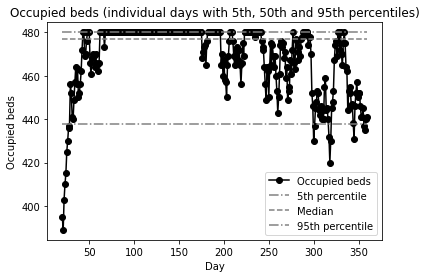

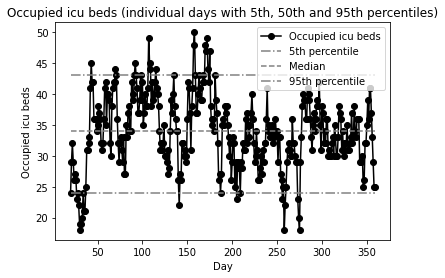

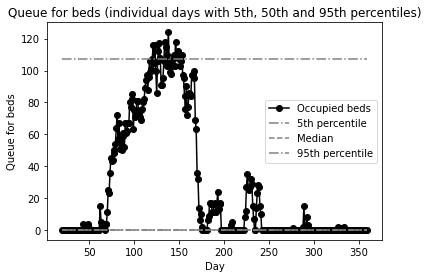

In [14]:
model.hospital.chart()